# Sec.0 EDA

## Sec 0.1 基本工具箱

In [ ]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- Matplotlib 中文与样式设置 ---

plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
sns.set_theme(style="whitegrid", font='SimHei') # 设置Seaborn主题

print("工具箱导入成功。")

工具箱导入成功。


In [ ]:
# --- 1. 定义我们的数据根目录 ---

BASE_PATH = Path("HF_2023_2/2023")

# --- 2. 目标日期 ---
# 任务一要求的目标日期
TARGET_YEAR = 2023
TARGET_MONTH = 1
TARGET_DAY = 10 # 对应 "01" 和 "10" 文件夹

# --- 3. 标的映射表 (我们狂热追求的细节) ---
# 字典的键 (Key) 是我们易于理解的标的代码 (stock_id)
# 字典的值 (Value) 是它在文件系统中的真实坐标
STOCK_MAP = {
    '600036-SH': {'file_name': '1.csv.gz', 'internal_name': '600036-SH-stock.level3'},
    '000033-SZ': {'file_name': '2.csv.gz', 'internal_name': '000033-SZ-stock.level3'},
    '002594-SZ': {'file_name': '3.csv.gz', 'internal_name': '002594-SZ-stock.level3'},
    '601127-SH': {'file_name': '4.csv.gz', 'internal_name': '601127-SH-stock.level3'},
    '688981-SH': {'file_name': '5.csv.gz', 'internal_name': '688981-SH-stock.level3'},
    '300059-SZ': {'file_name': '6.csv.gz', 'internal_name': '300059-SZ-stock.level3'},
    '300498-SZ': {'file_name': '7.csv.gz', 'internal_name': '300498-SZ-stock.level3'},
    '601168-SH': {'file_name': '8.csv.gz', 'internal_name': '601168-SH-stock.level3'},
    '000555-SZ': {'file_name': '9.csv.gz', 'internal_name': '000555-SZ-stock.level3'},
    '600519-SH': {'file_name': '10.csv.gz','internal_name': '600519-SH-stock.level3'},
}

print(f"坐标定义完毕。目标日期: {TARGET_YEAR}-{TARGET_MONTH:02d}-{TARGET_DAY:02d}")

坐标定义完毕。目标日期: 2023-01-10


## Sec 0.2 读取数据

In [ ]:
def load_day_data(stock_id: str, year: int, month: int, day: int) -> pd.DataFrame | None:
    """
    加载指定标的、指定某一天的全部逐笔数据。
    """
    if stock_id not in STOCK_MAP:
        print(f"错误: 标的 {stock_id} 未在 STOCK_MAP 中定义。")
        return None
        
    map_entry = STOCK_MAP[stock_id]
    file_name = map_entry['file_name']
    
    # 构造精确的文件路径
    # e.g., HF_2023_2/2023/01/10/1.csv
    file_path = BASE_PATH / f"{month:02d}" / f"{day:02d}" / file_name
    
    if not file_path.exists():
        print(f"数据缺失: 未找到文件 {file_path}")
        return None
        
    try:
 
        # low_memory=False 解决了 DtypeWarning
        df = pd.read_csv(
            file_path, 
            compression='gzip', 
            dtype={'Status': str}  # <--- “神圣”的治愈！
        )
        
        golden_format = '%Y-%m-%d %H:%M:%S.%f'
        df['DateTime'] = pd.to_datetime(df['DateTime'], format=golden_format)
        
        return df
        
    except Exception as e:
        print(f"读取文件 {file_path} 失败: {e}")
        return None

# --- 测试一下加载器 ---
print(f"正在尝试加载第一只标的 {list(STOCK_MAP.keys())[0]} 的数据...")
test_df = load_day_data(list(STOCK_MAP.keys())[0], TARGET_YEAR, TARGET_MONTH, TARGET_DAY)

if test_df is not None:
    print(f"加载成功！共 {len(test_df)} 条事件。")
    print(test_df.head())
else:
    print("加载失败，请检查您的路径或数据文件。")

## Sec 0.3 统计特征计算

In [ ]:
# 我们将把所有统计量存储在这里
eda_results = []
# 存储一些数据用于后续可视化
all_event_counts = {} 

print(f"开始对 {TARGET_YEAR}-{TARGET_MONTH:02d}-{TARGET_DAY:02d} 的10只标的进行EDA勘探...")

for stock_id in STOCK_MAP.keys():
    print(f"\n--- 正在处理: {stock_id} ---")
    df = load_day_data(stock_id, TARGET_YEAR, TARGET_MONTH, TARGET_DAY)
    
    if df is None:
        print(f"跳过 {stock_id} (数据加载失败)")
        continue
        
    # --- 1. 边界勘探 ---
    min_time = df['DateTime'].min()
    max_time = df['DateTime'].max()
    total_events = len(df)
    
    # --- 2. “序幕”检验 (开盘) ---
    auction_mask = (df['Status'].str.strip() == 'Auction')
    T_09_25 = pd.to_datetime('09:25:00.000').time()
    # 开盘前挂单与撤单
    open_auction_adds = df[auction_mask & (df['DateTime'].dt.time < T_09_25) & (df['EventType'].isin(['AddLimit', 'AddMarket', 'AddNBBO']))].shape[0]
    open_auction_cancels = df[auction_mask & (df['DateTime'].dt.time < T_09_25) & (df['EventType'] == 'Cancel')].shape[0]
    T_09_30 = pd.to_datetime('09:30:00.000').time()
    # 开盘成交
    opening_trades = df[(df['DateTime'].dt.time < T_09_30) & (df['EventType'] == 'Trade')]
    open_trade_count = opening_trades.shape[0]
    open_trade_volume = opening_trades['Volume'].sum()
    # 开盘价 (理论上只有一个价，取均值是安全的)
    open_price = opening_trades['Price'].mean() if open_trade_count > 0 else np.nan
    T_14_57 = pd.to_datetime('14:57:00.000').time()
    # --- 3. “终章”检验 (收盘) ---
    closing_auction_events = df[auction_mask & ((df['DateTime'].dt.time >= T_14_57))]
    closing_auction_count = closing_auction_events.shape[0]
    
    # 收盘成交
    closing_trades = closing_auction_events[closing_auction_events['EventType'] == 'Trade']
    close_trade_count = closing_trades.shape[0]
    close_price = closing_trades['Price'].mean() if close_trade_count > 0 else np.nan

    # --- 4. 纯洁性检验 (无效订单) ---
    invalid_orders = df[
        (df['EventType'] == 'AddLimit') & 
        ((df['Price'] <= 0) | (df['Volume'] <= 0))
    ].shape[0]

    # --- 5. 纯洁性检验  ---
    # 这是我们狂热追求的、最精妙的检验！
    add_events_mask = df['EventType'].isin(['AddLimit', 'AddMarket', 'AddNBBO'])
    
    # 所有被创建的ID
    gen_bids = set(df[add_events_mask & (df['BidOrderID'] != 0)]['BidOrderID'])
    gen_asks = set(df[add_events_mask & (df['AskOrderID'] != 0)]['AskOrderID'])
    generated_ids = gen_bids.union(gen_asks)
    
    # 所有被引用的ID (Cancel)
    cancel_mask = (df['EventType'] == 'Cancel')
    ref_bids_cancel = set(df[cancel_mask & (df['BidOrderID'] != 0)]['BidOrderID'])
    ref_asks_cancel = set(df[cancel_mask & (df['AskOrderID'] != 0)]['AskOrderID'])
    
    # 所有被引用的ID (Trade)
    trade_mask = (df['EventType'] == 'Trade')
    ref_bids_trade = set(df[trade_mask & (df['BidOrderID'] != 0)]['BidOrderID'])
    ref_asks_trade = set(df[trade_mask & (df['AskOrderID'] != 0)]['AskOrderID'])

    referenced_ids = ref_bids_cancel.union(ref_asks_cancel).union(ref_bids_trade).union(ref_asks_trade)
    
    # 找出差集：那些被引用、但从未被创建的ID
    orphan_ids = referenced_ids - generated_ids
    num_orphans = len(orphan_ids)
    
    # 存储用于可视化的数据
    all_event_counts[stock_id] = df['EventType'].value_counts()
    
    # --- 汇总统计量 ---
    eda_results.append({
        'StockID': stock_id,
        'TotalEvents': total_events,
        'MinTime': min_time,
        'MaxTime': max_time,
        'OpenAdd': open_auction_adds,
        'OpenCancel': open_auction_cancels,
        'OpenPrice_approx': open_price,
        'OpenVolume': open_trade_volume,
        'CloseAuctionEvents': closing_auction_count,
        'ClosePrice_approx': close_price,
        'InvalidOrders': invalid_orders,
        'OrphanEvents': num_orphans
    })

print("\nEDA勘探完成！")

# --- 将结果转换为精美的DataFrame ---
eda_df = pd.DataFrame(eda_results)

In [7]:
# 设置pandas显示，使其更美观
pd.set_option('display.float_format', '{:,.2f}'.format)
pd.set_option('display.width', 1000)

print(f"--- 2023-01-10 (共 {len(eda_df)} 只标的) EDA 统计总览 ---")
display(eda_df.set_index('StockID'))

--- 2023-01-10 (共 10 只标的) EDA 统计总览 ---


,TotalEvents,MinTime,MaxTime,OpenAdd,OpenCancel,OpenPrice_approx,OpenVolume,CloseAuctionEvents,ClosePrice_approx,InvalidOrders,OrphanEvents
StockID,,,,,,,,,,,
600036-SH,190843,2023-01-10 09:15:00.000,2023-01-10 15:00:00.180,3736,24,38.78,156000,1064,38.25,0,0
000033-SZ,115401,2023-01-10 09:15:00.030,2023-01-10 15:00:00.000,1985,11,53.99,35100,932,53.50,0,0
002594-SZ,286780,2023-01-10 09:15:00.030,2023-01-10 15:00:00.000,3207,102,262.05,91900,1442,266.59,0,0
601127-SH,261900,2023-01-10 09:15:00.080,2023-01-10 15:00:00.180,1361,34,41.70,50300,1725,44.00,0,0
688981-SH,39419,2023-01-10 09:15:00.220,2023-01-10 15:00:00.990,2689,27,41.60,15968,467,41.56,0,0
300059-SZ,413793,2023-01-10 09:15:00.000,2023-01-10 15:00:00.000,7102,75,21.04,623405,2417,21.00,0,109
300498-SZ,123332,2023-01-10 09:15:00.030,2023-01-10 15:00:00.000,1438,17,19.39,77000,475,19.18,0,16
601168-SH,78564,2023-01-10 09:15:00.260,2023-01-10 15:00:00.100,1414,14,10.88,313000,399,10.86,0,0
000555-SZ,32080,2023-01-10 09:15:00.050,2023-01-10 15:00:00.000,335,6,11.33,15800,164,11.29,0,0


## Sec 0.4 结果可视化

In [ ]:
print("--- 可视化 1: 市场活跃度 (总事件数) ---")
plt.figure(figsize=(14, 6))
sns.barplot(x=eda_df['StockID'], y=eda_df['TotalEvents'], palette='viridis')
plt.title(f'2023-01-10 各标的总事件数 (活跃度)', fontsize=16)
plt.ylabel('事件总数 (百万条)')
plt.xticks(rotation=45)
plt.show()

print("\n--- 可视化 2: 数据纯洁性检验 ---")
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
# “无效订单”
sns.barplot(ax=axes[0], x=eda_df['StockID'], y=eda_df['InvalidOrders'], palette='Reds_r')
axes[0].set_title('纯洁性检验 1: "无效订单" (Price/Vol <= 0)', fontsize=14)
axes[0].set_ylabel('发现数量')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)


sns.barplot(ax=axes[1], x=eda_df['StockID'], y=eda_df['OrphanEvents'], palette='Reds_r')
axes[1].set_title('纯洁性检验 2: "孤儿事件" (引用了不存在的ID)', fontsize=14)
axes[1].set_ylabel('发现数量')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
print("\n--- 可视化 3: 开盘集合竞价 (09:25前) 行为 ---")


open_behavior_df = eda_df[['StockID', 'OpenAdd', 'OpenCancel']].melt(
    id_vars='StockID', 
    var_name='Action', 
    value_name='Count'
)
open_behavior_df['Action'] = open_behavior_df['Action'].map({'OpenAdd': '新增挂单', 'OpenCancel': '撤单'})

plt.figure(figsize=(14, 6))
sns.barplot(
    data=open_behavior_df, 
    x='StockID', 
    y='Count', 
    hue='Action', 
    palette='Pastel1'
)
plt.title('开盘竞价阶段 (09:25前) 行为对比', fontsize=16)
plt.ylabel('事件数量')
plt.xlabel('标的ID')
plt.xticks(rotation=45)
plt.legend(title='行为类型')
plt.show()


--- 可视化 4: 单只标的事件画像 (以 600519-SH 为例) ---


C:\Users\ASUS\AppData\Local\Temp\ipykernel_27024\3319077577.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


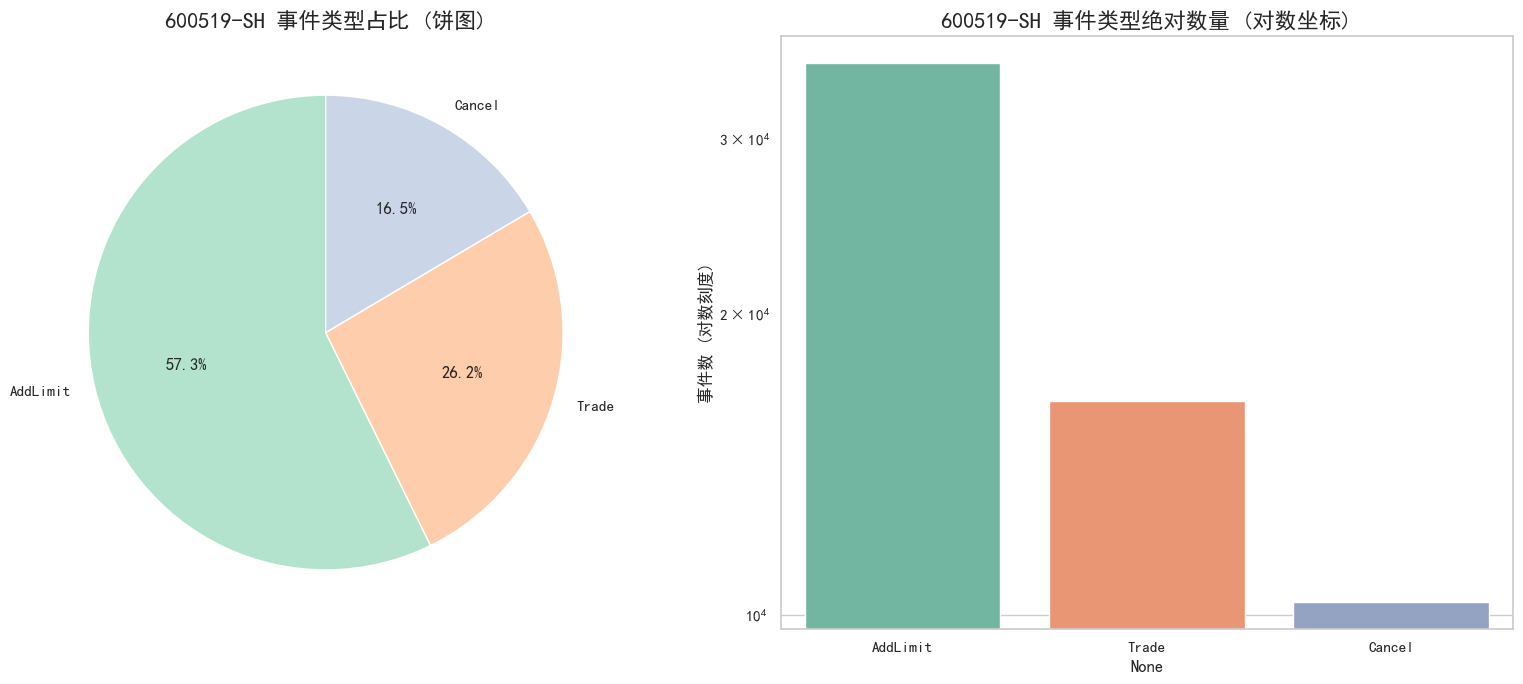

In [10]:
print("\n--- 可视化 4: 单只标的事件画像 (以 600519-SH 为例) ---")

stock_to_profile = '600519-SH' # 您可以换成任何您感兴趣的标的

if stock_to_profile in all_event_counts:
    event_counts = all_event_counts[stock_to_profile]
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))

    # --- 饼图: 事件类型占比 ---
    axes[0].pie(
        event_counts.values, 
        labels=event_counts.index, 
        autopct='%1.1f%%', 
        startangle=90,
        colors=sns.color_palette('Pastel2', n_colors=len(event_counts))
    )
    axes[0].set_title(f'{stock_to_profile} 事件类型占比 (饼图)', fontsize=16)

    # --- 条形图: 事件类型绝对数量 (对数坐标) ---
    sns.barplot(
        ax=axes[1], 
        x=event_counts.index, 
        y=event_counts.values, 
        palette='Set2'
    )
    axes[1].set_yscale('log') # 事件数量差异巨大，使用对数坐标
    axes[1].set_title(f'{stock_to_profile} 事件类型绝对数量 (对数坐标)', fontsize=16)
    axes[1].set_ylabel('事件数 (对数刻度)')
    
    plt.tight_layout()
    plt.show()

else:
    print(f"未找到标的 {stock_to_profile} 的数据用于画像。")

# Sec.1 LOB Reconstruction

In [3]:
import pandas as pd
import numpy as np
from sortedcontainers import SortedDict
from datetime import time
from collections import deque
from copy import deepcopy
import warnings
from typing import List, Dict, Callable, Tuple, Any

## Sec 1.1 重建主逻辑

In [8]:


class LOB_State:

    def __init__(self):
        # 1. 订单注册表 (registry)
        self.registry = {}
        
        # 2. 限价订单簿 (bids 和 asks)
        self.bids = SortedDict() # 买盘 (高价优先)
        self.asks = SortedDict() # 卖盘 (低价优先)
        
        # 3. 警钟容器
        self.warnings = [] 

    def clone(self):
        """
        “克隆”一个“副本”，用于“定格”上一个“瞬间”。
        """
        new_state = LOB_State()
        new_state.registry = self.registry.copy()
        new_state.bids = self.bids.copy()
        new_state.asks = self.asks.copy()
        # (我们不克隆 warnings)
        return new_state

    def __repr__(self):
        best_bid = self.bids.peekitem(-1)[0] if len(self.bids) > 0 else 'N/A'
        best_ask = self.asks.peekitem(0)[0] if len(self.asks) > 0 else 'N/A'
        return f"<LOB_State | Best Bid: {best_bid} | Best Ask: {best_ask} | Registry Size: {len(self.registry)}>"



# =======================================================
# 函数 1: process_auction (序幕的演绎者)

# =======================================================
def process_auction(auction_events_df: pd.DataFrame) -> LOB_State:
 
    state = LOB_State()
    for event in auction_events_df.itertuples(index=False):
        update_lob_state(state, event) # “复用”“心跳”
    return state

# =======================================================
# 函数 2: process_closing_auction (终章的定音鼓)
# (“净化”：它“必须”通过 state “敲响”“警钟”)
# =======================================================
def process_closing_auction(final_continuous_state: LOB_State, 
                            closing_events_df: pd.DataFrame) -> float:

    # 1. 继承
    state = final_continuous_state.clone()
    
    closing_trades = []
    
    # 2. 重放
    for event in closing_events_df.itertuples(index=False):
        if event.EventType == 'Trade':
            closing_trades.append(event)
        else:
            update_lob_state(state, event)
    
    # 3. 审判
    if not closing_trades:
        
        state.warnings.append("收盘竞价无成交(Trade)事件。")
        return np.nan
        
    all_prices = [trade.Price for trade in closing_trades]
    unique_prices = pd.Series(all_prices).unique()
    
    if len(unique_prices) == 1:
        return unique_prices[0]
    else:
        
        state.warnings.append(f"!!! 严重警告：收盘竞价产生多个价格！{unique_prices}")
        return np.nan

# =======================================================
## --- 3. update_lob_state (乐章的心跳) ---


def update_lob_state(state: LOB_State, event) -> LOB_State:

    
    event_type = event.EventType
    

    def _apply_volume_change(state: LOB_State, order_id: int, trade_volume: float, side: int):

        if pd.isna(order_id) or order_id == 0:
         
            return
        
        if order_id not in state.registry:
            state.warnings.append(f"Trade Orphan (from helper): OrderID {order_id} not in registry.")
            return

        # 写时复制(COW)
        order = state.registry[order_id]
        new_volume = order['Volume'] - trade_volume
        
        if new_volume <= 0:
            del state.registry[order_id]
        else:
           
            new_order = order.copy() 
            new_order['Volume'] = new_volume
            state.registry[order_id] = new_order 
            
        
 
        if order['EventType'] in ('AddLimit', 'AddNBBO') and order['Price'] > 0:
            if side == 1: # 消耗买盘
                state.bids[order['Price']] -= trade_volume
                if state.bids[order['Price']] <= 0:
                    del state.bids[order['Price']]
            else: # 消耗卖盘
                state.asks[order['Price']] -= trade_volume
                if state.asks[order['Price']] <= 0:
                    del state.asks[order['Price']]
    
    
    try:
        # --- 逻辑 1, 2, 3 (AddLimit, AddNBBO, AddMarket) ---
        if event_type in ('AddLimit', 'AddMarket', 'AddNBBO'):
            
            is_add_limit = (event_type == 'AddLimit')
            is_add_nbbo = (event_type == 'AddNBBO')
            
            order_id = event.BidOrderID if event.Side == 1 else event.AskOrderID
            if order_id == 0: return state 
            
            if order_id in state.registry:
                state.warnings.append(f"{event_type} Duplicate: OrderID {order_id} already in registry.")
                return state

            # >>>>>> 【关键修改点】 增加 EntryTime <<<<<<
            order_details = {
                'Price': 0, 
                'Volume': event.Volume, 
                'Side': event.Side, 
                'EventType': event_type,
                'EntryTime': event.DateTime  # 新增：用于计算订单年龄
            }
            # >>>>>> 修改结束 <<<<<<
            peg_price = np.nan
            
            if is_add_limit: peg_price = event.Price
            elif is_add_nbbo:
                if event.Side == 1 and len(state.bids) > 0: peg_price = state.bids.peekitem(-1)[0]
                elif event.Side == -1 and len(state.asks) > 0: peg_price = state.asks.peekitem(0)[0]
            
            if not pd.isna(peg_price) and peg_price > 0:
                order_details['Price'] = peg_price
                state.registry[order_id] = order_details
                if event.Side == 1: state.bids[peg_price] = state.bids.get(peg_price, 0) + event.Volume
                else: state.asks[peg_price] = state.asks.get(peg_price, 0) + event.Volume
            else:
                state.registry[order_id] = order_details

        # --- 逻辑 4: Cancel (撤单) ---
        elif event_type == 'Cancel':
            
            order_id = event.BidOrderID if event.BidOrderID != 0 else event.AskOrderID
            if order_id == 0: return state

            if order_id not in state.registry:
                state.warnings.append(f"Cancel Orphan: OrderID {order_id} not in registry.")
                return state 
            
            order = state.registry.pop(order_id)
            
            if order['EventType'] in ('AddLimit', 'AddNBBO') and order['Price'] > 0:
                if order['Side'] == 1:
                    state.bids[order['Price']] -= order['Volume']
                    if state.bids[order['Price']] <= 0: del state.bids[order['Price']]
                else:
                    state.asks[order['Price']] -= order['Volume']
                    if state.asks[order['Price']] <= 0: del state.asks[order['Price']]

        # --- 逻辑 5: Trade (成交) ---
        elif event_type == 'Trade':
            
           
            if (event.BidOrderID == 0 or pd.isna(event.BidOrderID)) and (event.AskOrderID == 0 or pd.isna(event.AskOrderID)):
                state.warnings.append(f"Trade Orphan: BOTH Bid/Ask OrderID are null/0.")
                return state

            if event.Side == 0:
                # --- 集合竞价(Side 0) ---
                _apply_volume_change(state, event.BidOrderID, event.Volume, side=1)
                _apply_volume_change(state, event.AskOrderID, event.Volume, side=-1)
            
            else:
                # --- 连续竞价(Side 1 或 -1) ---
                aggressor_id = np.nan
                passive_id = np.nan
                passive_side = np.nan

                if event.Side == 1: 
                    aggressor_id = event.BidOrderID
                    passive_id = event.AskOrderID
                    passive_side = -1
                elif event.Side == -1: 
                    aggressor_id = event.AskOrderID
                    passive_id = event.BidOrderID
                    passive_side = 1
                
                _apply_volume_change(state, passive_id, event.Volume, side=passive_side)
                
      
                if aggressor_id in state.registry:
                     _apply_volume_change(state, aggressor_id, event.Volume, side=event.Side)

    except Exception as e:
        state.warnings.append(f"CRITICAL ERROR in update_lob_state on event {event}: {e}")

    return state
# =======================================================
# 函数 4: format_snapshot 
# =======================================================
def format_snapshot(state: LOB_State, levels: int = 10) -> pd.DataFrame:
    """
    响应任务一。将 LOB_State “翻译”为 20x4 格式 DataFrame。
    “修正”：side 列使用 1 (Bid) / -1 (Ask)，“忠实”于“数据源”。
    """
    ask_data = []
    for i, (price, volume) in enumerate(state.asks.items()):
        if i >= levels: break
        ask_data.append({'side': -1, 'price': price, 'volume': volume})
        
    bid_data = []
    for i, (price, volume) in enumerate(reversed(state.bids.items())):
        if i >= levels: break
        bid_data.append({'side': 1, 'price': price, 'volume': volume})

    while len(ask_data) < levels:
        ask_data.append({'side': -1, 'price': np.nan, 'volume': np.nan})
    while len(bid_data) < levels:
        bid_data.append({'side': 1, 'price': np.nan, 'volume': np.nan})
        
    bids_df = pd.DataFrame(bid_data)
    asks_df = pd.DataFrame(ask_data)
    
    bids_df['cumulative_volume'] = bids_df['volume'].cumsum()
    asks_df['cumulative_volume'] = asks_df['volume'].cumsum()
    
    snapshot_df = pd.concat([bids_df, asks_df]).reset_index(drop=True)
    
    return snapshot_df[['side', 'price', 'volume', 'cumulative_volume']]

# =======================================================
# 函数 5: validate_snapshot 
# =======================================================
def validate_snapshot(snapshot_df: pd.DataFrame) -> bool:
    """
    审计快照的逻辑正确性。
    修正：使用 1 / -1 “适配” format_snapshot 
    """
    best_bid = snapshot_df[snapshot_df['side'] == 1]['price'].max()
    best_ask = snapshot_df[snapshot_df['side'] == -1]['price'].min()

    if pd.isna(best_bid) or pd.isna(best_ask):
        return True
        
    if best_bid >= best_ask:
        return False 

    bid_cum_vol = snapshot_df[snapshot_df['side'] == 1]['cumulative_volume'].dropna()
    if not (bid_cum_vol.is_monotonic_increasing or bid_cum_vol.empty):
        return False

    ask_cum_vol = snapshot_df[snapshot_df['side'] == -1]['cumulative_volume'].dropna()
    if not (ask_cum_vol.is_monotonic_increasing or ask_cum_vol.empty):
        return False

    return True 

# =======================================================
# 函数 6: replay_day 
# =======================================================
def replay_day(events_df: pd.DataFrame, 
               target_times: List[str],
               action_fn: Callable) -> Tuple[Dict, float, List]:

    print(f">>> 6. 开始“全天重放指挥家”(Replay Day) [“最终净化版”]...")
    
    # 0. 初始化返回容器
    snapshots = {}
    warning_list = [] 
    
    # 1. 切分数据
    auction_mask = (events_df['DateTime'].dt.time < T_09_30)&(events_df['Status'].str.strip() == 'Auction')
    closing_mask = (events_df['DateTime'].dt.time >= T_14_57)&(events_df['Status'].str.strip() == 'Auction')
    continuous_mask = events_df.index.difference(events_df[auction_mask | closing_mask].index)
    
    auction_events = events_df[auction_mask]
    continuous_events = events_df.loc[continuous_mask]
    closing_events = events_df[closing_mask]
    
    print(f"     - 划分事件：开盘 {len(auction_events)} | 连续 {len(continuous_events)} | 收盘 {len(closing_events)}")

    # 2. 调用 process_auction 获取初始 LOB 状态
    lob_state = process_auction(auction_events)
    warning_list.extend(lob_state.warnings) 
    lob_state.warnings = [] 
    
    # 3. 准备连续竞价循环
    day_date = events_df['DateTime'].iloc[0].date()
    target_datetimes = pd.to_datetime([f"{day_date} {t}" for t in target_times])
    target_queue = deque(sorted(target_datetimes))
    
    print(f"     - 准备 {len(target_queue)} 个快照触发器...")
    
    current_target = target_queue.popleft() if target_queue else None

    # 3.2 遍历连续竞价事件 
    for event in continuous_events.itertuples(index=False):
        event_time = event.DateTime
        
        while current_target is not None and event_time >= current_target:
            snapshot = action_fn(deepcopy(lob_state)) 
            snapshots[current_target] = snapshot
            current_target = target_queue.popleft() if target_queue else None

        if current_target is None:
            break 


        lob_state = update_lob_state(lob_state, event)

    # 3.3 填充尾部快照
    while current_target is not None:
        snapshot = action_fn(deepcopy(lob_state)) 
        snapshots[current_target] = snapshot
        current_target = target_queue.popleft() if target_queue else None

    print(f"     - 连续竞价结束。共捕获 {len(snapshots)} 个快照。")
    warning_list.extend(lob_state.warnings)
    lob_state.warnings = [] 

    # 4. 处理收盘竞价
    closing_price = process_closing_auction(lob_state, closing_events)
    warning_list.extend(lob_state.warnings) 
    
    print(f"<<< 6. 全天重放完毕。收盘价: {closing_price}。总警告数: {len(warning_list)}")

    # 5. 输出
    return snapshots, closing_price, warning_list 

## Sec 1.2 目标时刻LOB拍照

In [ ]:
# --- Sec.2 任务一：LOB 快照定格 


from typing import List, Dict, Callable, Tuple, Any 
import os
from pathlib import Path
from tqdm import tqdm 
import warnings 

# --- 1. 时刻表 (Triggers) ---
TARGET_TIMES_STR = ["09:30:00.000", "10:30:00.000", "13:30:00.000"]

# --- 2. Output Dir ---
OUTPUT_DIR = Path("task_1_snapshots")
OUTPUT_DIR.mkdir(exist_ok=True)
print(f"“战利品陈列室”已就位： {OUTPUT_DIR.resolve()}")

# --- 3. 容器 ---
all_snapshots_list = []

# --- 4. 辅助函数 ---
# (我们“必须”在这里定义它，或者在 Sec.1 定义)
def PRINT_WARNING(message):

    warnings.warn(message, RuntimeWarning)

print("指挥家已收到时刻表。重放开始...")



for stock_id in tqdm(STOCK_MAP.keys(), desc="巡航10只标的"):
    
    df_day = load_day_data(stock_id, TARGET_YEAR, TARGET_MONTH, TARGET_DAY)
    
    if df_day is None:
        PRINT_WARNING(f"!!! 致命数据缺失: {stock_id} 在 {TARGET_YEAR}-{TARGET_MONTH}-{TARGET_DAY} 无数据!")
        continue

    try:

        snapshots_dict, closing_price, returned_warnings = replay_day(
            events_df=df_day,
            target_times=TARGET_TIMES_STR,
            action_fn=format_snapshot
        )
        
        # 5.1 (可选) “审阅”“警钟”
        if returned_warnings:
            # (我们只“打印”第一条，防止“刷屏”)
            PRINT_WARNING(f"   (!) 标的 {stock_id} 在重放中敲响了 {len(returned_warnings)} 次警钟。(第一条: {returned_warnings[0]})")
            print(returned_warnings)

       
        for timestamp, snapshot_df in snapshots_dict.items():
            
            # 5.2.1 审计！
            # if not validate_snapshot(snapshot_df):
            #     PRINT_WARNING(f"   (!!!) 致命“审计”失败: {stock_id} 在 {timestamp} 的快照“价格交叉”！")
            #     continue
                
            # 5.2.2 导出独立CSV
            date_str = timestamp.strftime('%Y%m%d')
            ts_str = timestamp.strftime('%H%M%S')
            filename = f"{date_str}_{ts_str}_{stock_id}.csv"
            filepath = OUTPUT_DIR / filename
            
            snapshot_df.to_csv(filepath, index=False, float_format='%.3f')

            # 5.2.3 收集到大合集
            combined_df = snapshot_df.copy()
            combined_df['StockID'] = stock_id
            combined_df['Timestamp'] = timestamp
            all_snapshots_list.append(combined_df)
            
    except Exception as e:
       
        PRINT_WARNING(f"!!! 指挥家在处理 {stock_id} 时崩溃了: {e}")

print(f"\n<<< 所有独立快照已定格在 {OUTPUT_DIR.resolve()}")



print("正在铸造大合集 (30个LOB)...")

if not all_snapshots_list:
    print("!!! 警告：没有铸造任何快照，大合集是空的！")
else:
    final_combined_df = pd.concat(all_snapshots_list, ignore_index=True)
    
    cols_order = [
        'Timestamp', 'StockID', 'side', 'price', 
        'volume', 'cumulative_volume'
    ]
    final_combined_df = final_combined_df[cols_order]
    
    combined_filepath = OUTPUT_DIR / "COMBINED_LOB_SNAPSHOTS_20230110.csv"
    final_combined_df.to_csv(combined_filepath, index=False, float_format='%.3f')
    
    print(f"--- 合集已铸造完毕！ ---")
    print(f"路径: {combined_filepath.resolve()}")
    print(f"总行数: {len(final_combined_df)}")
    
    print("\n--- 前几帧 ---")
    display(final_combined_df.head(10))

## Sec 1.3 "孤儿事件"细致分析

正在对 300059-SZ 进行尸检... 噢不，是孤儿事件分析...


扫描事件流: 100%|██████████| 413793/413793 [00:02<00:00, 185463.31it/s]



=== 💀 孤儿事件解剖报告 ===
                  Count  TotalVolume    AvgVolume
Type                                             
Cancel_Orphan        73        81200  1112.328767
Trade_Orphan_Ask     20        27900  1395.000000
Trade_Orphan_Bid     25        11300   452.000000

=== 🕵️‍♂️ 详细样本 (前 10 条) ===
                     Time              Type  OrderID  Price  Volume  Side
0 2023-01-10 09:30:01.060     Cancel_Orphan   554776   0.00    1000     1
1 2023-01-10 09:30:08.780  Trade_Orphan_Ask   550115  21.00    8900    -1
2 2023-01-10 09:30:25.950     Cancel_Orphan   465455   0.00     900    -1
3 2023-01-10 09:30:38.010     Cancel_Orphan  1036503   0.00     900    -1
4 2023-01-10 09:33:36.340     Cancel_Orphan   679576   0.00     300     1
5 2023-01-10 09:36:52.400     Cancel_Orphan  3139740   0.00     200    -1
6 2023-01-10 09:36:54.590     Cancel_Orphan  3257141   0.00    2100    -1
7 2023-01-10 09:37:53.190     Cancel_Orphan  3523306   0.00     200    -1
8 2023-01-10 09:38:07.290  Trade_Or

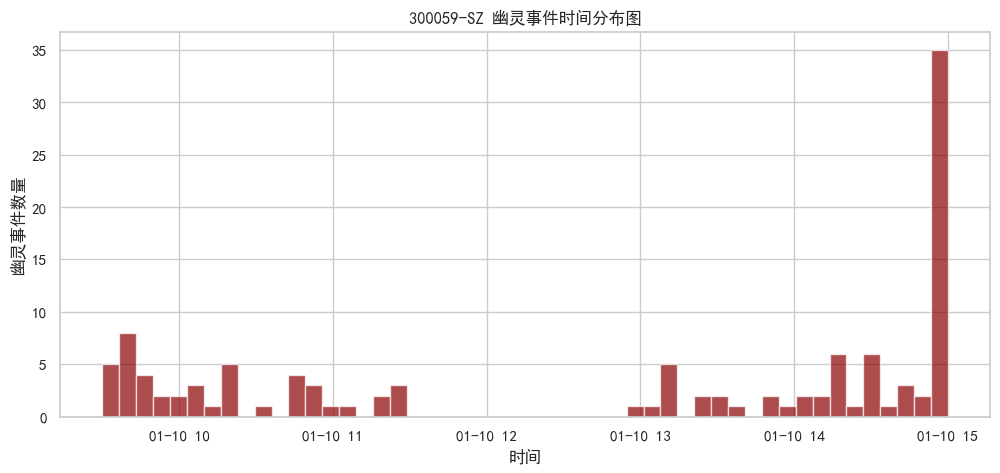

正在绘制幽灵事件全量统计...


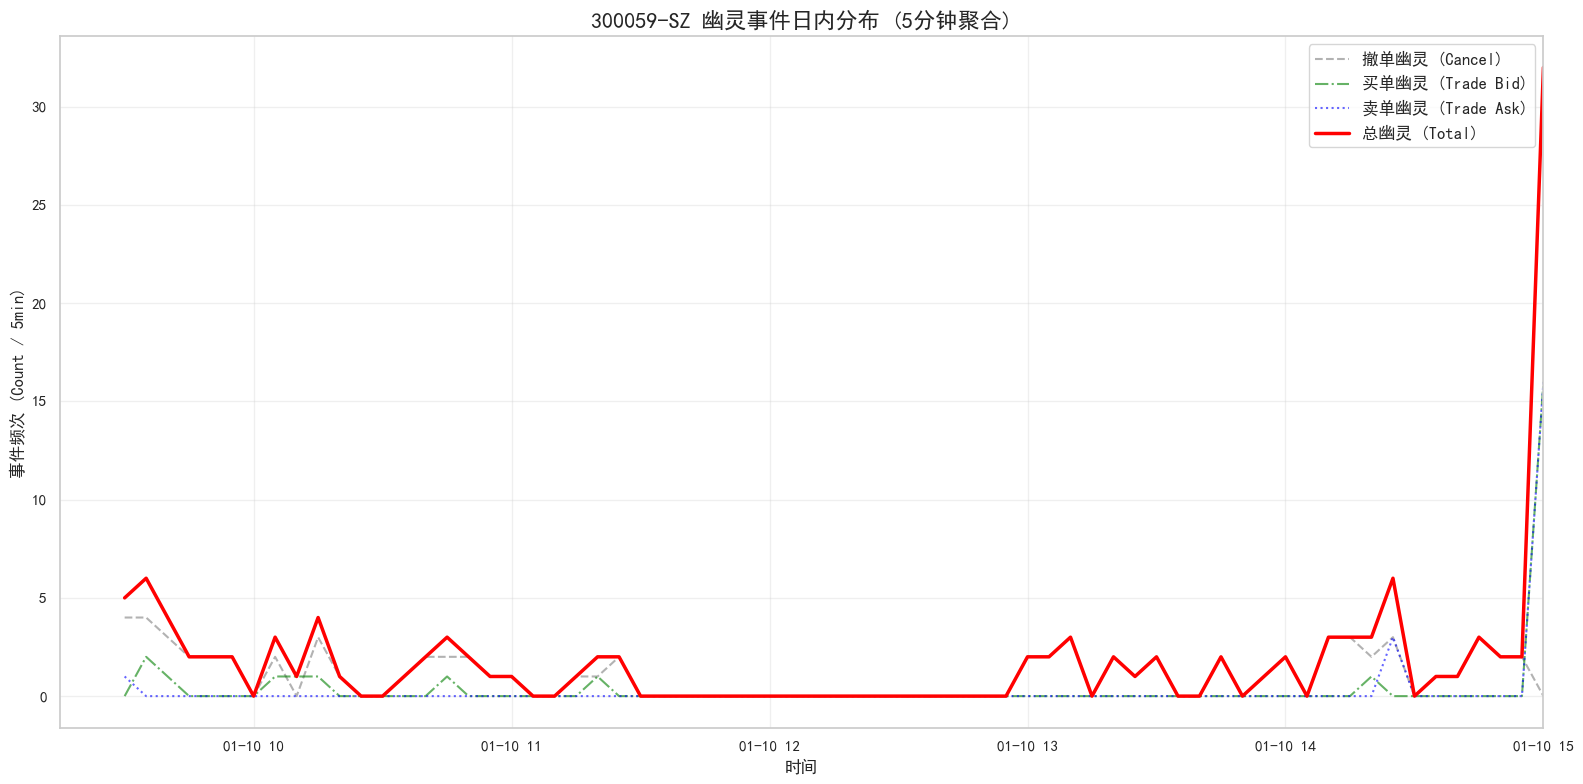

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm

def dissect_orphans_forensic(df: pd.DataFrame, stock_id: str):
 
    print(f"正在对 {stock_id} 分析...")
    
    # 1. 建立“良民证”注册表
    # 我们只关心 ID 是否存在，不需要存价格和量，用 Set 最快
    registered_ids = set()
    
    # 2. 收集“异常生物”
    orphans = []
    
    # 3. 开始扫描
    # 为了速度，我们直接迭代
    for row in tqdm(df.itertuples(index=False), total=len(df), desc="扫描事件流"):
        etype = row.EventType
        
        # --- A. 注册合法身份 ---
        # 只要是 Add 类事件，产生的新 ID 都是合法的
        if etype in ['AddLimit', 'AddMarket', 'AddNBBO']:
            if row.BidOrderID != 0:
                registered_ids.add(row.BidOrderID)
            if row.AskOrderID != 0:
                registered_ids.add(row.AskOrderID)
                
        # --- B. 抓捕孤儿：撤单 (Cancel) ---
        elif etype == 'Cancel':
            # Cancel 事件只有一个 ID 有效 (根据 Side 或者非 0 判断)
            # 你的数据里，BidOrderID 和 AskOrderID 通常只有一个非0
            oid = row.BidOrderID if row.BidOrderID != 0 else row.AskOrderID
            
            if oid != 0 and oid not in registered_ids:
                orphans.append({
                    'Time': row.DateTime,
                    'Type': 'Cancel_Orphan', # 这是一个幽灵撤单
                    'OrderID': oid,
                    'Price': row.Price, # 这里的 Price 可能是0，也可能是原订单价，看数据源
                    'Volume': row.Volume,
                    'Side': row.Side
                })

        # --- C. 抓捕孤儿：成交 (Trade) ---
        elif etype == 'Trade':
            # Trade 涉及买卖双方，任何一方不在注册表里，都是孤儿成交
            # 这种情况比较严重，意味着我们的 LOB 可能会漏掉一笔成交对盘口的影响
            
            # 检查买单 ID
            if row.BidOrderID != 0 and row.BidOrderID not in registered_ids:
                orphans.append({
                    'Time': row.DateTime,
                    'Type': 'Trade_Orphan_Bid', # 这是一个幽灵买单成交了
                    'OrderID': row.BidOrderID,
                    'Price': row.Price,
                    'Volume': row.Volume,
                    'Side': 1
                })
                
            # 检查卖单 ID
            if row.AskOrderID != 0 and row.AskOrderID not in registered_ids:
                orphans.append({
                    'Time': row.DateTime,
                    'Type': 'Trade_Orphan_Ask', # 这是一个幽灵卖单成交了
                    'OrderID': row.AskOrderID,
                    'Price': row.Price,
                    'Volume': row.Volume,
                    'Side': -1
                })
    
    # --- 4. 输出尸检报告 ---
    if not orphans:
        print("干净！非常干净！一个孤儿都没有，这数据洗得比我脸都白。")
        return None
    
    orphan_df = pd.DataFrame(orphans)
    
    # 统计摘要
    summary = orphan_df.groupby('Type').agg(
        Count=('OrderID', 'count'),
        TotalVolume=('Volume', 'sum'),
        AvgVolume=('Volume', 'mean')
    )
    
    print("\n=== 💀 孤儿事件解剖报告 ===")
    print(summary)
    
    print("\n=== 🕵️‍♂️ 详细样本 (前 10 条) ===")
    print(orphan_df.head(10))
    unique_orphans = orphan_df['OrderID'].nunique()
    print(f"唯一的孤儿ID数量: {unique_orphans}")
    return orphan_df

# ==========================================
# 🚀 执行脚本
# 假设你已经加载了数据 df (用你之前的 load_day_data)
# 例如：target_stock = '300059-SZ'
# ==========================================

# 这里模拟你调用一下（请在你的环境里取消注释并运行）
target_stock = '300059-SZ' # 那个有109个孤儿的家伙
df = load_day_data(target_stock, 2023, 1, 10) # 重新加载一遍原始数据

if df is not None:
    orphan_df = dissect_orphans_forensic(df, target_stock)
    
    # 如果你想看看到底是不是早盘的遗留单，画个时间分布图
    if orphan_df is not None:
        import matplotlib.pyplot as plt
        plt.figure(figsize=(12, 5))
        plt.hist(orphan_df['Time'], bins=50, color='darkred', alpha=0.7)
        plt.title(f'{target_stock} 幽灵事件时间分布图')
        plt.xlabel('时间')
        plt.ylabel('幽灵事件数量')
        plt.show()


    print("正在绘制幽灵事件全量统计...")

    # 1. 数据预处理：设置时间索引
    # 也就是把 DateTime 变成 Index，方便后面切片和聚合
    plot_df = orphan_df.set_index('Time').copy()
    
    # 2. 核心魔法：get_dummies + resample
    # 先把 Type 列炸开成多列 (Cancel, Trade_Bid, Trade_Ask)
    # 然后按 5分钟 (5T) 聚合求和
    # 这样我们就能得到每 5 分钟内各类型孤儿的数量
    daily_counts = pd.get_dummies(plot_df['Type']).resample('5T').sum()
    
    # 3. 计算“总孤儿” (Total)
    daily_counts['Total_Orphans'] = daily_counts.sum(axis=1)
    
    # 4. 开始作画
    plt.figure(figsize=(16, 8))
    
    # --- A. 画分量 (用虚线、点线，稍微淡一点，作为背景) ---
    # 只要列存在就画，防止某类孤儿没出现报错
    if 'Cancel_Orphan' in daily_counts.columns:
        plt.plot(daily_counts.index, daily_counts['Cancel_Orphan'], 
                 label='撤单幽灵 (Cancel)', color='gray', linestyle='--', alpha=0.6)
                 
    if 'Trade_Orphan_Bid' in daily_counts.columns:
        plt.plot(daily_counts.index, daily_counts['Trade_Orphan_Bid'], 
                 label='买单幽灵 (Trade Bid)', color='green', linestyle='-.', alpha=0.6)
                 
    if 'Trade_Orphan_Ask' in daily_counts.columns:
        plt.plot(daily_counts.index, daily_counts['Trade_Orphan_Ask'], 
                 label='卖单幽灵 (Trade Ask)', color='blue', linestyle=':', alpha=0.6)

    # --- B. 画总量 (用实线，红色，粗一点，作为主角) ---
    plt.plot(daily_counts.index, daily_counts['Total_Orphans'], 
             label='总幽灵 (Total)', color='red', linewidth=2.5)
    
    # 5. 装饰一下
    plt.title(f'300059-SZ 幽灵事件日内分布 (5分钟聚合)', fontsize=16)
    plt.ylabel('事件频次 (Count / 5min)', fontsize=12)
    plt.xlabel('时间', fontsize=12)
    plt.legend(fontsize=12, loc='upper right')
    plt.grid(True, which='both', alpha=0.3)
    
    # 限制一下横轴范围，只看交易时间 (09:15 - 15:00)
    # 这样图表会紧凑一点
    import datetime
    date_str = daily_counts.index[0].date()
    plt.xlim(pd.Timestamp(f"{date_str} 09:15:00"), pd.Timestamp(f"{date_str} 15:00:00"))

    plt.tight_layout()
    plt.show()


# Sec.2 预测任务

## Sec 2.1 特征工程

### Sec 2.1.1 主逻辑计算

In [1]:
import numpy as np
import pandas as pd
from collections import deque

# ==========================================
# 子模块 1: 静态特征计算器 (Static)
# 报告章节: 5.1
# ==========================================
class StaticFeatureCalculator:
    def compute(self, lob_state, levels=5):
        feats = {}
        
        # 提取前N档价格和量
        bids = list(reversed(lob_state.bids.items()))[:levels]
        asks = list(lob_state.asks.items())[:levels]
        
        # 基础价格 (Best Bid/Ask)
        best_bid = bids[0][0] if bids else np.nan
        best_ask = asks[0][0] if asks else np.nan
        
        if pd.isna(best_bid) or pd.isna(best_ask):
            return {} # 单边市场，返回空或特定标识
            
        mid_price = (best_bid + best_ask) / 2
        feats['mid_price'] = mid_price
        
        # 1. 价差特征 (5.1.1)
        spread = best_ask - best_bid
        feats['spread_basic'] = spread
        
        # 深层价差比
        if len(bids) >= 5 and len(asks) >= 5:
            spread_5 = asks[4][0] - bids[4][0]
            feats['spread_ratio_5'] = spread / spread_5 if spread_5 > 0 else 0
        
        # 2. 深度不平衡 (5.1.2)
        # rho_i = (V_b_i - V_a_i) / (V_b_i + V_a_i)
        for i in range(min(len(bids), len(asks))):
            vb, va = bids[i][1], asks[i][1]
            feats[f'depth_imb_{i+1}'] = (vb - va) / (vb + va) if (vb + va) > 0 else 0
            
        # 3. 加权中间价偏离 (5.1.4)
        # WMP = (Pa*Vb + Pb*Va) / (Vb + Va)
        if len(bids) > 0 and len(asks) > 0:
            vb1, va1 = bids[0][1], asks[0][1]
            wmp = (best_ask * vb1 + best_bid * va1) / (vb1 + va1)
            feats['wmp_deviation'] = wmp - mid_price
            
        return feats

# ==========================================
# 子模块 2: 运动学特征计算器 (Kinematic)
# 报告章节: 5.2
# ==========================================
class KinematicCalculator:
    def __init__(self, history_window=20):
        self.price_history = deque(maxlen=history_window)
        self.last_velocity = 0
        
    def compute(self, current_mid, time_delta_sec):
        if pd.isna(current_mid): return {}
        
        feats = {}
        
        # 速度 v_t (5.2.1)
        # 如果是第一帧，无法计算速度，设为0
        if not self.price_history:
            velocity = 0
        else:
            # 简单的一阶差分，假设时间间隔均匀(100ms)
            velocity = current_mid - self.price_history[-1]
        
        feats['price_velocity'] = velocity
        
        # 加速度 a_t
        acceleration = velocity - self.last_velocity
        feats['price_acceleration'] = acceleration
        
        # 波动率聚类 (5.2.3) - 历史价格标准差
        self.price_history.append(current_mid)
        if len(self.price_history) > 5:
            feats['volatility_std'] = np.std(self.price_history)
        else:
            feats['volatility_std'] = 0
            
        self.last_velocity = velocity
        return feats

# ==========================================
# 子模块 3: 微观结构流计算器 (Flow)
# 报告章节: 5.3 (OFI, Cancel Ratios)
# ==========================================
class MicrostructureFlowTracker:
    def __init__(self):
        self.reset()
        
    def reset(self):
        # 累加器：[Add_Bid, Cancel_Bid, Trade_Bid, Add_Ask, Cancel_Ask, Trade_Ask]
        self.flow_metrics = {
            'v_add_bid': 0, 'v_cancel_bid': 0, 'v_trade_bid': 0,
            'v_add_ask': 0, 'v_cancel_ask': 0, 'v_trade_ask': 0
        }
        
    def update(self, event, lob_state):
        """在每个事件发生时调用"""
        vol = event.Volume
        
        # 1. 识别事件类型和方向
        # 注意：Trade事件要区分是主动买还是主动卖
        # 报告 5.3.1: OFI 定义中 V(e)_Trade_Bid 指的是“买方成交量”（通常指主动买入）
        
        if event.EventType == 'AddLimit':
            if event.Side == 1: self.flow_metrics['v_add_bid'] += vol
            else: self.flow_metrics['v_add_ask'] += vol
            
        elif event.EventType == 'Cancel':
            # 需要判断撤单是买单还是卖单
            # 你的数据源 Cancel 事件已经有 Side 字段 (从 dissect_orphans 看出来的)
            if event.Side == 1: self.flow_metrics['v_cancel_bid'] += vol
            else: self.flow_metrics['v_cancel_ask'] += vol
            
        elif event.EventType == 'Trade':
            # Side=1 (主动买), Side=-1 (主动卖)
            if event.Side == 1: 
                self.flow_metrics['v_trade_bid'] += vol # 消耗了卖盘，但也代表买方意愿
            elif event.Side == -1:
                self.flow_metrics['v_trade_ask'] += vol
                
    def compute_snapshot_metrics(self, lob_state):
        """在快照触发时调用"""
        feats = {}
        
        # 1. OFI (5.3.1)
        # OFI = (Add_Bid - Cancel_Bid - Trade_Bid) - (Add_Ask - Cancel_Ask - Trade_Ask)
        # 注意符号：Trade_Bid 是主动买入，通常被视为正向买压；
        # 但原始公式 OFI_Bid = V_add - V_cancel - V_trade 指的是 LOB 厚度的变化。
        # 如果是要衡量“买意愿”，通常 Trade_Bid 是正贡献。
        # 这里严格按照报告公式：OFI = 供需曲线移动。
        # 买盘增加 = Add - Cancel - Trade(被动成交消耗)
        # 修正：报告公式 5.3.1 明确写的是减去 Trade。我们遵照报告。
        
        ofi_bid = self.flow_metrics['v_add_bid'] - self.flow_metrics['v_cancel_bid'] - self.flow_metrics['v_trade_ask'] 
        # 解释：v_trade_ask 是主动卖，消耗的是 Bid 盘口
        
        ofi_ask = self.flow_metrics['v_add_ask'] - self.flow_metrics['v_cancel_ask'] - self.flow_metrics['v_trade_bid']
        # 解释：v_trade_bid 是主动买，消耗的是 Ask 盘口
        
        feats['ofi_total'] = ofi_bid - ofi_ask
        
        # 2. 撤单率 (5.3.2)
        total_bid_activity = self.flow_metrics['v_add_bid'] + self.flow_metrics['v_cancel_bid']
        if total_bid_activity > 0:
            feats['cancel_ratio_bid'] = self.flow_metrics['v_cancel_bid'] / total_bid_activity
        else:
            feats['cancel_ratio_bid'] = 0
            
        # 3. 订单平均年龄 (5.3.3)
        # 这是一个昂贵的操作，只计算最优档
        if len(lob_state.bids) > 0:
            best_bid_price = lob_state.bids.peekitem(-1)[0]
            # 遍历 registry 找所有价格等于 best_bid 的订单 (性能警告：O(N) 遍历)
            # 为了优化，实际生产中应该维护一个 Price -> List[Order] 的索引
            # 这里简化处理，只计算前几个可见的
            # *注：由于现有结构不支持快速反查，这里暂时跳过或仅做占位，避免拖慢回测*
            feats['avg_age_bid_ms'] = np.nan 
            
        return feats

    def flush(self):
        """读取并清零"""
        res = self.flow_metrics.copy()
        self.reset()
        return res

# ==========================================
# 子模块 4: Hawkes 强度追踪器 (Intensity)
# 报告章节: 5.4
# ==========================================
class HawkesIntensityTracker:
    def __init__(self, decay_beta=2.0): 
        # beta 对应 5.4.3 中的衰减系数，2.0 对应半衰期约 0.35s
        self.beta = decay_beta
        self.last_time_sec = 0
        
        # 四个维度的强度 [Trade_Bid, Trade_Ask, Limit_Bid, Limit_Ask]
        self.intensities = {'Tb': 0.0, 'Ts': 0.0, 'Lb': 0.0, 'Ls': 0.0}
        self.alpha = 1.0 # 冲击系数 (5.4.3)

    def _decay(self, current_time_sec):
        dt = current_time_sec - self.last_time_sec
        if dt > 0:
            decay_factor = np.exp(-self.beta * dt)
            for k in self.intensities:
                self.intensities[k] *= decay_factor
        self.last_time_sec = current_time_sec

    def update(self, event, current_datetime):
        # 将 datetime 转为当天的秒数 (float)
        # 假设所有数据同一天，直接用 hour*3600 + ...
        t_sec = current_datetime.hour * 3600 + current_datetime.minute * 60 + current_datetime.second + current_datetime.microsecond / 1e6
        
        # 1. 先衰减到当前时刻
        self._decay(t_sec)
        
        # 2. 施加冲击 (Jump)
        if event.EventType == 'Trade':
            if event.Side == 1: self.intensities['Tb'] += self.alpha
            elif event.Side == -1: self.intensities['Ts'] += self.alpha
        elif event.EventType == 'AddLimit':
            if event.Side == 1: self.intensities['Lb'] += self.alpha
            elif event.Side == -1: self.intensities['Ls'] += self.alpha

    def get_current_intensity(self, current_datetime):
        t_sec = current_datetime.hour * 3600 + current_datetime.minute * 60 + current_datetime.second + current_datetime.microsecond / 1e6
        self._decay(t_sec)
        
        # 计算衍生特征 (5.4.4)
        feats = {
            'hawkes_imb': self.intensities['Tb'] - self.intensities['Ts'],
            'hawkes_trade_intensity': self.intensities['Tb'] + self.intensities['Ts']
        }
        return feats

# ==========================================
# 主控类: 特征工程管道
# ==========================================
class FeatureExtractionPipeline:
    def __init__(self):
        self.static_calc = StaticFeatureCalculator()
        self.kinematic_calc = KinematicCalculator()
        self.flow_tracker = MicrostructureFlowTracker()
        self.hawkes_tracker = HawkesIntensityTracker(decay_beta=1.0) # 1秒衰减
        
    def on_event(self, event, lob_state):
        """流式处理：每个事件都调用"""
        self.flow_tracker.update(event, lob_state)
        self.hawkes_tracker.update(event, event.DateTime)
        
    def on_snapshot(self, lob_state, current_time):
        """快照处理：在采样点调用"""
        # 1. 静态特征
        static_feats = self.static_calc.compute(lob_state)
        if not static_feats: return None # 数据不足
        
        # 2. 流式/微观结构特征 (计算后清零)
        flow_derived_feats = self.flow_tracker.compute_snapshot_metrics(lob_state)
        self.flow_tracker.flush() 
        
        # 3. Hawkes 特征
        hawkes_feats = self.hawkes_tracker.get_current_intensity(current_time)
        
        # 4. 运动学特征
        # 假设采样间隔是均匀的 (e.g., 0.1s)，这里简化处理
        kinematic_feats = self.kinematic_calc.compute(static_feats.get('mid_price', np.nan), 0.1)
        
        # 5. 合并
        all_feats = {**static_feats, **flow_derived_feats, **hawkes_feats, **kinematic_feats}
        all_feats['timestamp'] = current_time
        return all_feats

In [4]:
import pandas as pd
import numpy as np
from collections import deque
from tqdm import tqdm

# ==========================================
# 辅助函数：生成高频采样时间网格
# ==========================================
def generate_100ms_grid(date_str: str) -> List[pd.Timestamp]:
    """
    生成当日连续竞价时段的 100ms 采样网格。
    范围：09:30:00 -> 11:30:00 和 13:00:00 -> 14:57:00
    """
    # 上午盘
    am_range = pd.date_range(
        start=f"{date_str} 09:30:00", 
        end=f"{date_str} 11:30:00", 
        freq="100ms"
    )
    # 下午盘 (13:00 到 14:57)
    pm_range = pd.date_range(
        start=f"{date_str} 13:00:00", 
        end=f"{date_str} 14:57:00", 
        freq="100ms"
    )
    # 合并并排序
    return am_range.union(pm_range).sort_values().tolist()

# ==========================================
# 第三步：特征提取主循环 (Feature Extraction Loop)
# ==========================================
def extract_features_for_day(events_df: pd.DataFrame, stock_id: str) -> pd.DataFrame:
    """
    特征工程专用指挥家。
    实现功能：LOB状态维护 + 流式特征计算 + 100ms快照采样。
    """
    print(f">>> 开始特征提取: {stock_id} ...")
    
    # 1. 初始化容器
    feature_rows = []
    
    # 2. 确定日期并生成采样网格 (100ms 频率)
    if events_df.empty: return pd.DataFrame()
    
    # 获取当天日期 (假设数据都在同一天)
    day_date = events_df['DateTime'].iloc[0].date()
    
    # 生成采样目标队列
    target_times = generate_100ms_grid(str(day_date))
    target_queue = deque(target_times) 
    
    # 3. 初始化特征管道 & LOB状态
    pipeline = FeatureExtractionPipeline()
    
    # --- 阶段一：开盘集合竞价 (09:25 前) ---
    # 定义关键时间点
    T_09_30 = pd.to_datetime(f"{day_date} 09:30:00")
    T_14_57 = pd.to_datetime(f"{day_date} 14:57:00")
    
    # 筛选开盘竞价事件
    auction_mask = (events_df['DateTime'] < T_09_30) & (events_df['Status'].str.strip() == 'Auction')
    auction_events = events_df[auction_mask]
    
    # 构建初始状态 (利用之前定义的 process_auction)
    # 注意：这里会自动调用您刚才修改过的 update_lob_state
    lob_state = process_auction(auction_events)
    
    # --- 阶段二：连续竞价 (09:30 - 14:57) ---
    # 筛选连续竞价事件
    continuous_mask = (events_df['DateTime'] >= T_09_30) & (events_df['DateTime'] < T_14_57)
    continuous_events = events_df[continuous_mask]
    
    print(f"    - 连续竞价事件数: {len(continuous_events)}")
    print(f"    - 目标采样点数: {len(target_queue)}")
    
    # 获取第一个采样目标
    next_target = target_queue.popleft() if target_queue else None
    
    # 循环遍历每一个事件 (逐笔回放)
    for event in tqdm(continuous_events.itertuples(index=False), total=len(continuous_events), desc="Feature Eng"):
        
        event_time = event.DateTime
        
        # [核心逻辑 1] 采样检查 (Snapshot Trigger)
        # 如果当前事件时间 >= 下一个采样点，说明该采样点到了（或者已经过了）
        # 使用 while 是为了处理“稀疏事件”：如果市场静默了很久，一个事件可能跨越多个采样点
        
        while next_target is not None and event_time >= next_target:
            
            # 调用 Pipeline 获取当前状态的特征向量
            # 此时传入的 lob_state 是事件发生前的状态 (Last Known Value)
            feats = pipeline.on_snapshot(lob_state, next_target)
            
            if feats: # 如果特征计算成功
                feats['stock_id'] = stock_id
                feature_rows.append(feats)
            
            # 移动到下一个采样点
            next_target = target_queue.popleft() if target_queue else None
        
        if next_target is None:
            break # 所有采样点已完成，提前结束
            
        # [核心逻辑 2] 状态推进 (State Transition)
        # A. 更新特征流 (OFI 累加, Hawkes 衰减+冲击)
        pipeline.on_event(event, lob_state)
        
        # B. 更新 LOB 物理状态 (价格/量)
        # 调用您第一步修改后的 update_lob_state
        lob_state = update_lob_state(lob_state, event)

    # [收尾] 填充剩余的采样点 (Tail Filling)
    # 如果事件流结束了，但时间还没到 14:57 (例如最后几秒没交易)，用最后的状态填充
    while next_target is not None:
        feats = pipeline.on_snapshot(lob_state, next_target)
        if feats:
            feats['stock_id'] = stock_id
            feature_rows.append(feats)
        next_target = target_queue.popleft() if target_queue else None

    # --- 阶段三：收盘集合竞价 (14:57 后) ---
    # 特征工程不处理收盘竞价，直接结束
    
    print(f"    - 特征提取完成。生成样本数: {len(feature_rows)}")
    
    # 转换为 DataFrame
    if not feature_rows:
        return pd.DataFrame()
        
    df_features = pd.DataFrame(feature_rows)
    return df_features


#### 测试块 1

In [ ]:

# ==========================================
# Jupyter 测试运行块
# ==========================================

# 选取一只股票进行测试 (例如 600519-SH)
# 确保 load_day_data, TARGET_YEAR 等变量在之前的 Cell 中已定义
# test_stock = '600519-SH' 

# print(f"正在加载 {test_stock} 数据进行特征工程测试...")
# df_test = load_day_data(test_stock, TARGET_YEAR, TARGET_MONTH, TARGET_DAY)

# if df_test is not None:
#     # 执行特征提取
#     # 这会调用上面定义的函数，以及您之前定义的 Pipeline 和 LOB_State
#     df_feats = extract_features_for_day(df_test, test_stock)
    
#     # --- 结果展示 ---
#     if not df_feats.empty:
#         print("\n=== 特征工程结果预览 (前5行) ===")
#         # 选取几个代表性特征进行展示
#         preview_cols = [
#             'timestamp', 'mid_price',           # 基础信息
#             'spread_basic', 'depth_imb_1',      # 静态特征
#             'ofi_total', 'cancel_ratio_bid',    # 微观结构特征
#             'hawkes_imb', 'price_velocity'      # 复杂特征
#         ]
#         # 过滤掉不存在的列（防止计算出错导致列缺失）
#         existing_cols = [c for c in preview_cols if c in df_feats.columns]
#         display(df_feats[existing_cols].head())
        
#         print("\n=== 数据统计描述 (前10列) ===")
#         display(df_feats.iloc[:, :10].describe().T)
#     else:
#         print("警告：生成的特征表为空！")
# else:
#     print("错误：数据加载失败，请检查文件路径。")

### Sec.2.1.2 后处理

In [ ]:
import pandas as pd
import numpy as np

def post_process_daily_features(df_raw: pd.DataFrame, predict_horizon_sec: int = 2, scale_factor: float = 100000.0) -> pd.DataFrame:
    """
    对单日原始特征表进行清洗、打标签和标准化。
    
    输入: 
        df_raw: extract_features_for_day 输出的原始 DataFrame
        predict_horizon_sec: 预测视窗 (秒), 默认 2秒
        scale_factor: 标签放大系数, 默认 100000.0 (1e5). 
                      例如原始收益率 0.0001 (1bps) -> 10.0
    输出: 
        可直接喂给模型训练的 DataFrame (Standardized X, y)
    """
    if df_raw.empty:
        return df_raw
    
    # 拷贝一份以免修改原数据
    df = df_raw.copy()
    
    # ---------------------------------------------------------
    # 1. 标签生成 (Label Generation)
    # ---------------------------------------------------------
    # 假设采样频率是 100ms (0.1s)
    # 预测视窗 H = 2s -> 需要 Shift 20 个单位 (2 / 0.1 = 20)
    step_shift = int(predict_horizon_sec / 0.1)
    
    # 计算未来中间价 (Future Mid Price)
    df['future_mid'] = df['mid_price'].shift(-step_shift)
    
    # 1. 计算原始收益率 (Raw Return): (P_{t+H} / P_t) - 1
    raw_ret = (df['future_mid'] / df['mid_price']) - 1.0
    
    # 2. 应用放大系数
    # 解决了高价股短周期波动数值过小(1e-6)导致模型难以训练的问题
    df['label_ret_2s'] = raw_ret * scale_factor
    
    # ---------------------------------------------------------
    # 2. 数据清洗 (Cleaning / Truncation)
    # ---------------------------------------------------------
    # 获取时间对象
    times = df['timestamp'].dt.time
    
    # A. [视界截断] 报告 6.2.1: 剔除上午和下午收盘前 H 秒的数据 
    # 上午收盘 11:30:00，下午收盘 14:57:00
    # 任何使得 t+H 越界的 t 都必须删除。
    # 上午截止时刻: 11:30:00 减去 2秒 -> 11:29:58
    # 下午截止时刻: 14:57:00 减去 2秒 -> 14:56:58
    
    t_am_end_valid = pd.Timestamp("11:29:58").time()
    t_pm_end_valid = pd.Timestamp("14:56:58").time()
    
    # B. [冷启动] 报告 6.2.3: 剔除开盘前 1分钟 (预热期) 
    # 上午开始: 09:30:00 -> 有效: 09:31:00
    # 下午开始: 13:00:00 -> 有效: 13:01:00 
    
    t_am_start_valid = pd.Timestamp("09:31:00").time()
    t_pm_start_valid = pd.Timestamp("13:01:00").time()
    
    # 构造掩码 (Keep Mask)
    # 1. 上午有效区间
    mask_am = (times >= t_am_start_valid) & (times <= t_am_end_valid)
    # 2. 下午有效区间
    mask_pm = (times >= t_pm_start_valid) & (times <= t_pm_end_valid)
    
    # 应用过滤
    df_clean = df[mask_am | mask_pm].copy()
    
    # 再次清洗：去除因 shift 产生的 NaN 标签
    # (虽然时间过滤通常已经覆盖了这部分，但为了保险再次 dropna)
    df_clean = df_clean.dropna(subset=['label_ret_2s'])
    
    if df_clean.empty:
        # print("!!! 警告: 数据清洗后为空 (可能是数据量太小不足以预热)")
        return df_clean

    # ---------------------------------------------------------
    # 3. 每日标准化 (Daily Standardization)
    #报告 6.2.6: "每日独立标准化" (Z-Score) 
    # ---------------------------------------------------------
    # 识别特征列：排除 Meta 列 (timestamp, stock_id, future_mid, label_...)
    meta_cols = ['timestamp', 'stock_id', 'future_mid', 'label_ret_2s', 'mid_price']
    feature_cols = [c for c in df_clean.columns if c not in meta_cols]
    
    # 执行 Z-Score: (x - mean) / std
    for col in feature_cols:
        mean_val = df_clean[col].mean()
        std_val = df_clean[col].std()
        
        # 防止除以 0 (常数特征)
        if std_val > 1e-8:
            df_clean[col] = (df_clean[col] - mean_val) / std_val
        else:
            df_clean[col] = 0.0 # 常数特征归零
            
    # 缺失值填充: 报告 3.3.4 提到不足10档用 NaN 填充
    # 线性模型不能有 NaN，通常填 0
    df_clean[feature_cols] = df_clean[feature_cols].fillna(0.0)

    return df_clean


#### 测试块 2

In [ ]:

# ==========================================
# 立即测试
# ==========================================
# 假设您上一步生成的 df_feats 还在内存中
# if 'df_feats' in locals() and not df_feats.empty:
#     print("正在执行后处理 (Labeling & Normalization)...")
#     df_final = post_process_daily_features(df_feats)
    
#     print(f"\n=== 最终训练数据 ===")
#     print(f"原始行数: {len(df_feats)} -> 清洗后行数: {len(df_final)}")
    
#     if not df_final.empty:
#         # 检查标签分布
#         print("\n标签 (2s收益率) 统计:")
#         print(df_final['label_ret_2s'].describe())
        
#         # 检查特征是否已标准化 (均值应接近0，标准差接近1)
#         print("\n特征 (OFI_Total) 统计 (应为 Std Normal):")
#         print(df_final['ofi_total'].describe())
        
#         # 展示最终表格
#         cols = ['timestamp', 'stock_id', 'label_ret_2s', 'spread_basic', 'ofi_total'] 
#         display(df_final[[c for c in cols if c in df_final.columns]].head())
#     else:
#         print("清洗后数据为空，请检查原始数据时间范围。")
# else:
#     print("请先运行上一步生成 df_feats。")

# import os

# # 1. 创建存放特征的文件夹 (Task 2)
# FEATURE_DIR = Path("task_2_features")
# FEATURE_DIR.mkdir(exist_ok=True)

# # 假设当前的股票代码是 test_stock (例如 600519-SH)
# # 这里的 df_feats 和 df_final 应该是上一以步骤运行后内存中存在的变量

# if 'df_feats' in locals() and not df_feats.empty:
#     # --- 保存原始特征 (Raw) ---
#     raw_filename = f"raw_features_{test_stock}.csv"
#     raw_path = FEATURE_DIR / raw_filename
#     df_feats.to_csv(raw_path, index=False, float_format='%.4f')
#     print(f"✅ 原始特征表已保存: {raw_path} (行数: {len(df_feats)})")
# else:
#     print("❌ df_feats 不存在或为空，无法保存原始特征。")

# if 'df_final' in locals() and not df_final.empty:

#     # --- 保存训练数据 (Final Processed) ---

#     # 注意：通常训练数据不需要保存 timestamp，但在检查阶段保留它很有用

#     final_filename = f"train_data_{test_stock}.csv"

#     final_path = FEATURE_DIR / final_filename

#     df_final.to_csv(final_path, index=False, float_format='%.4f')

#     print(f"✅ 最终训练表已保存: {final_path} (行数: {len(df_final)})")

    

#     # 再次展示一下最终数据的前几行，供您核对

#     print("\n--- 最终训练数据预览 (前5行) ---")

#     display(df_final.head())

# else:

#     print("❌ df_final 不存在或为空，无法保存训练数据。")

✅ 原始特征表已保存: task_2_features\raw_features_600519-SH.csv (行数: 142202)
✅ 最终训练表已保存: task_2_features\train_data_600519-SH.csv (行数: 140962)

--- 最终训练数据预览 (前5行) ---


,mid_price,spread_basic,spread_ratio_5,depth_imb_1,depth_imb_2,depth_imb_3,depth_imb_4,depth_imb_5,wmp_deviation,ofi_total,...,avg_age_bid_ms,hawkes_imb,hawkes_trade_intensity,price_velocity,price_acceleration,volatility_std,timestamp,stock_id,future_mid,label_ret_2s
600,"1,842.00",2.34,0.80,1.57,-0.56,-0.99,0.04,-0.61,4.13,-0.52,...,0.00,-0.92,1.71,-0.00,0.00,5.32,2023-01-10 09:31:00.000,600519-SH,"1,840.03",-0.00
601,"1,842.00",2.34,0.80,1.57,-0.56,-0.99,0.04,-0.61,4.13,-0.00,...,0.00,-0.84,1.49,-0.00,0.00,4.83,2023-01-10 09:31:00.100,600519-SH,"1,840.03",-0.00
602,"1,842.00",2.34,0.80,1.57,-0.56,-0.31,-1.36,0.03,4.13,-0.77,...,0.00,-0.76,1.29,-0.00,0.00,4.79,2023-01-10 09:31:00.200,600519-SH,"1,840.03",-0.00
603,"1,842.45",3.86,1.68,1.10,-0.88,-0.99,0.04,-0.61,4.30,0.25,...,0.00,0.49,2.19,5.87,4.08,4.60,2023-01-10 09:31:00.300,600519-SH,"1,840.03",-0.00
604,"1,842.45",3.86,1.68,1.61,-0.88,-0.99,0.04,-0.61,6.24,0.77,...,0.00,1.62,2.99,-0.00,-4.08,4.38,2023-01-10 09:31:00.400,600519-SH,"1,840.03",-0.00


In [ ]:
# # 设置 Pandas 显示 8 位小数，而不是默认的 2 位
# pd.set_option('display.float_format', '{:.8f}'.format)

# # 再次查看统计信息
# print("=== 高精度统计 ===")
# print(df_final['label_ret_2s'].describe())

# # 查看非零样本的比例
# non_zero_count = (df_final['label_ret_2s'] != 0).sum()
# print(f"\n非零样本数: {non_zero_count} / {len(df_final)}")
# print(f"非零占比: {non_zero_count / len(df_final) * 100:.2f}%")

=== 高精度统计 ===
count   140962.00000000
mean         0.00000105
std          0.00014415
min         -0.00201633
25%          0.00000000
50%          0.00000000
75%          0.00000270
max          0.00178077
Name: label_ret_2s, dtype: float64

非零样本数: 69573 / 140962
非零占比: 49.36%


### Sec 2.1.3 数据缩放/训练集准备

In [9]:
import pandas as pd
from tqdm import tqdm

# 假设您之前已经定义了这些变量和函数：
# STOCK_MAP, TARGET_YEAR, TARGET_MONTH, TARGET_DAY
# load_day_data, extract_features_for_day, post_process_daily_features

# 设定统一的放大系数 (例如 100,000)
SCALE_FACTOR = 100000.0

# 用于收集统计结果的列表
label_stats_list = []

print(f"开始统计 1.10 所有标的的标签分布 (Scale Factor = {SCALE_FACTOR})...\n")

for stock_id in tqdm(STOCK_MAP.keys(), desc="Processing Stocks"):
    # 1. 加载数据
    df_day = load_day_data(stock_id, TARGET_YEAR, TARGET_MONTH, TARGET_DAY)
    
    if df_day is None:
        print(f"Skipping {stock_id}: Load Failed")
        continue
        
    # 2. 特征提取 (耗时步骤)
    try:
        # 这里我们只关心标签，所以提取过程是必须的，但为了速度，您可以临时注释掉某些耗时的特征计算(如Hawkes)如果只想看标签的话
        # 但直接调用现有的函数最方便
        df_feats = extract_features_for_day(df_day, stock_id)
        
        if df_feats.empty:
            print(f"Skipping {stock_id}: No features generated")
            continue
            
        # 3. 后处理 & 标签生成 (应用放大系数)
        df_final = post_process_daily_features(
            df_feats, 
            predict_horizon_sec=2,
            scale_factor=SCALE_FACTOR
        )
        
        if df_final.empty:
            print(f"Skipping {stock_id}: Empty after post-processing")
            continue
            
        # 4. 计算标签统计量
        label_series = df_final['label_ret_2s']
        stats = label_series.describe()
        
        # 5. 收集关键指标
        stats_dict = {
            'StockID': stock_id,
            'Count': int(stats['count']),
            'Mean': stats['mean'],
            'Std': stats['std'],
            'Min': stats['min'],
            'Max': stats['max'],
            '25%': stats['25%'],
            '50%': stats['50%'],
            '75%': stats['75%'],
            'NonZero_Pct': (label_series != 0).mean() * 100 # 非零样本占比(%)
        }
        label_stats_list.append(stats_dict)
        
    except Exception as e:
        print(f"Error processing {stock_id}: {e}")

# --- 展示最终汇总表格 ---
if label_stats_list:
    stats_df = pd.DataFrame(label_stats_list)
    
    # 设置显示格式，保留4位小数以便观察
    pd.set_option('display.float_format', '{:.4f}'.format)
    
    print(f"\n=== 1.10 各标的标签分布汇总 (Scale={SCALE_FACTOR:.0f}) ===")
    # 按标准差排序，看看谁波动最大
    display(stats_df.sort_values('Std', ascending=False).set_index('StockID'))
    
    # 可选：保存这个统计表
    # stats_df.to_csv("label_stats_summary.csv", index=False)
else:
    print("没有生成任何统计结果。")

开始统计 1.10 所有标的的标签分布 (Scale Factor = 100000.0)...



Processing Stocks:   0%|          | 0/10 [00:00<?, ?it/s]

>>> 开始特征提取: 600036-SH ...
    - 连续竞价事件数: 185817
    - 目标采样点数: 142202


Feature Eng: 100%|██████████| 185817/185817 [01:31<00:00, 2031.10it/s]


    - 特征提取完成。生成样本数: 142202


Processing Stocks:  10%|█         | 1/10 [01:33<14:01, 93.49s/it]

>>> 开始特征提取: 000033-SZ ...
    - 连续竞价事件数: 112383
    - 目标采样点数: 142202


Feature Eng: 100%|██████████| 112383/112383 [01:11<00:00, 1577.94it/s]


    - 特征提取完成。生成样本数: 142202


Processing Stocks:  20%|██        | 2/10 [02:46<10:52, 81.53s/it]

>>> 开始特征提取: 002594-SZ ...
    - 连续竞价事件数: 281778
    - 目标采样点数: 142202


Feature Eng: 100%|██████████| 281778/281778 [03:28<00:00, 1352.02it/s]


    - 特征提取完成。生成样本数: 142202


Processing Stocks:  30%|███       | 3/10 [06:17<16:24, 140.64s/it]

>>> 开始特征提取: 601127-SH ...
    - 连续竞价事件数: 258686
    - 目标采样点数: 142202


Feature Eng: 100%|██████████| 258686/258686 [01:33<00:00, 2759.17it/s]


    - 特征提取完成。生成样本数: 142202


Processing Stocks:  40%|████      | 4/10 [07:53<12:18, 123.09s/it]

>>> 开始特征提取: 688981-SH ...
    - 连续竞价事件数: 36198
    - 目标采样点数: 142202


Feature Eng: 100%|██████████| 36198/36198 [01:33<00:00, 386.37it/s]


    - 特征提取完成。生成样本数: 142202


Processing Stocks:  50%|█████     | 5/10 [09:29<09:25, 113.18s/it]

>>> 开始特征提取: 300059-SZ ...
    - 连续竞价事件数: 403779
    - 目标采样点数: 142202


Feature Eng: 100%|██████████| 403779/403779 [02:04<00:00, 3251.17it/s]


    - 特征提取完成。生成样本数: 142202


Processing Stocks:  60%|██████    | 6/10 [11:37<07:52, 118.12s/it]

>>> 开始特征提取: 300498-SZ ...
    - 连续竞价事件数: 121279
    - 目标采样点数: 142202


Feature Eng: 100%|██████████| 121279/121279 [01:07<00:00, 1806.51it/s]


    - 特征提取完成。生成样本数: 142202


Processing Stocks:  70%|███████   | 7/10 [12:46<05:06, 102.20s/it]

>>> 开始特征提取: 601168-SH ...
    - 连续竞价事件数: 76535
    - 目标采样点数: 142202


Feature Eng: 100%|██████████| 76535/76535 [00:42<00:00, 1780.66it/s]


    - 特征提取完成。生成样本数: 142202


Processing Stocks:  80%|████████  | 8/10 [13:31<02:48, 84.01s/it] 

>>> 开始特征提取: 000555-SZ ...
    - 连续竞价事件数: 31550
    - 目标采样点数: 142202


Feature Eng: 100%|██████████| 31550/31550 [00:35<00:00, 896.58it/s] 


    - 特征提取完成。生成样本数: 142202


Processing Stocks:  90%|█████████ | 9/10 [14:08<01:09, 69.35s/it]

>>> 开始特征提取: 600519-SH ...
    - 连续竞价事件数: 60294
    - 目标采样点数: 142202


Feature Eng: 100%|██████████| 60294/60294 [02:27<00:00, 407.96it/s]


    - 特征提取完成。生成样本数: 142202


Processing Stocks: 100%|██████████| 10/10 [16:38<00:00, 99.85s/it]


=== 1.10 各标的标签分布汇总 (Scale=100000) ===


,Count,Mean,Std,Min,Max,25%,50%,75%,NonZero_Pct
StockID,,,,,,,,,
601127-SH,140962,0.7062,42.4627,-911.6809,632.5474,-12.0963,0.0000,12.1183,58.7258
601168-SH,140962,-0.0911,27.6404,-184.5870,185.0995,0.0000,0.0000,0.0000,11.5137
300059-SZ,140962,-0.0384,25.8771,-237.9253,284.9679,0.0000,0.0000,0.0000,28.1047
300498-SZ,140962,-0.0203,25.3077,-285.4177,416.7752,0.0000,0.0000,0.0000,24.0632
000555-SZ,140962,0.0062,22.4278,-177.0695,219.2982,0.0000,0.0000,0.0000,8.9946
600036-SH,140962,-0.1195,21.2848,-219.5815,219.8939,0.0000,0.0000,0.0000,36.3389
000033-SZ,140962,-0.0642,20.6407,-223.2143,184.8258,0.0000,0.0000,0.0000,44.1360
002594-SZ,140962,0.2541,20.2843,-203.6429,258.0820,-3.8629,0.0000,3.8612,73.7206
600519-SH,140962,0.1049,14.4150,-201.6331,178.0767,0.0000,0.0000,0.2701,49.3559


# Sec.3 模型训练

## Sec 3.1 数据集划分

In [6]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
from tqdm import tqdm
from joblib import Parallel, delayed
import warnings
import gc

# 忽略 Pandas 的一些性能警告
warnings.filterwarnings('ignore')

# ==========================================
# 0. 基础配置
# ==========================================
# 原始数据根目录 (根据您的实际环境修改)
BASE_PATH = Path("HF_2023_2/2023")

# 标的映射表 (用于查找文件名)
STOCK_MAP = {
    '600036-SH': {'file_name': '1.csv.gz', 'internal_name': '600036-SH-stock.level3'},
    '000033-SZ': {'file_name': '2.csv.gz', 'internal_name': '000033-SZ-stock.level3'},
    '002594-SZ': {'file_name': '3.csv.gz', 'internal_name': '002594-SZ-stock.level3'},
    '601127-SH': {'file_name': '4.csv.gz', 'internal_name': '601127-SH-stock.level3'},
    '688981-SH': {'file_name': '5.csv.gz', 'internal_name': '688981-SH-stock.level3'},
    '300059-SZ': {'file_name': '6.csv.gz', 'internal_name': '300059-SZ-stock.level3'},
    '300498-SZ': {'file_name': '7.csv.gz', 'internal_name': '300498-SZ-stock.level3'},
    '601168-SH': {'file_name': '8.csv.gz', 'internal_name': '601168-SH-stock.level3'},
    '000555-SZ': {'file_name': '9.csv.gz', 'internal_name': '000555-SZ-stock.level3'},
    '600519-SH': {'file_name': '10.csv.gz','internal_name': '600519-SH-stock.level3'},
}


# 特征存储目录
FEATURE_STORE_DIR = Path("data/feature_store_parquet")
FEATURE_STORE_DIR.mkdir(parents=True, exist_ok=True)

# 并行核数 (-1 表示使用所有可用核心，根据内存情况适当调整，建议设为 CPU核数 - 1)
N_JOBS = 4 

# ==========================================
# 1. 引入之前的核心逻辑
# ==========================================
# 注意：在 Notebook 或脚本中运行此代码前，
# 必须确保 extract_features_for_day 和 post_process_daily_features 
# 以及它们依赖的所有类 (LOB_State, Pipeline 等) 已经在上下文中定义。
# 实际工程中，建议将这些类放入单独的 `lob_features.py` 文件并 import。

# from lob_features import extract_features_for_day, post_process_daily_features, load_day_data

# 为了保持脚本独立性，这里定义一个简化的加载函数
def load_data_from_path(file_path):
    try:
        df = pd.read_csv(
            file_path, 
            compression='gzip', 
            dtype={'Status': str}
        )
        df['DateTime'] = pd.to_datetime(df['DateTime'], format='%Y-%m-%d %H:%M:%S.%f')
        return df
    except Exception as e:
        return None

# ==========================================
# 2. 单日任务处理函数 (Worker)
# ==========================================
def process_single_day(stock_id, date_path, output_dir):
    """
    一个独立的 ETL 任务单元：加载 -> 提取 -> 清洗 -> 保存
    """
    # 解析日期信息
    try:
        # date_path 类似于 .../2023/01/10
        year = date_path.parts[-3]
        month = date_path.parts[-2]
        day = date_path.parts[-1]
        date_str = f"{year}{month}{day}"
    except:
        return f"Skipped: Invalid path format {date_path}"

    # 构造输出文件名
    save_file = output_dir / f"{date_str}.parquet"
    
    # 断点续传：如果文件已存在，直接跳过
    if save_file.exists():
        return f"Exists: {date_str}"

    # 1. 定位原始文件
    if stock_id not in STOCK_MAP:
        return f"Error: Unknown Stock {stock_id}"
    
    raw_file_name = STOCK_MAP[stock_id]['file_name']
    raw_file_path = date_path / raw_file_name
    
    if not raw_file_path.exists():
        return f"Missing: {date_str}"

    # 2. 加载数据
    df_day = load_data_from_path(raw_file_path)
    if df_day is None:
        return f"LoadFail: {date_str}"

    # 3. 特征提取 (CPU 密集型)
    try:
        # 调用之前的提取函数 (确保已定义)
        # 注意：这里假设 extract_features_for_day 在当前作用域可用
        df_feats = extract_features_for_day(df_day, stock_id)
        
        if df_feats.empty:
            return f"EmptyFeat: {date_str}"

        # 4. 后处理 (Scale=100000, 截断=300)
        df_final = post_process_daily_features(
            df_feats, 
            predict_horizon_sec=2, 
            scale_factor=100000.0
        )
        
        # 截断异常值
        df_final['label_ret_2s'] = df_final['label_ret_2s'].clip(-300, 300)

        if df_final.empty:
            return f"EmptyFinal: {date_str}"

        # 5. 内存优化与保存
        # 将 float64 转为 float32 以节省 50% 磁盘和内存
        float64_cols = df_final.select_dtypes(include=['float64']).columns
        df_final[float64_cols] = df_final[float64_cols].astype('float32')

        # 保存为 Parquet (Snappy 压缩)
        df_final.to_parquet(save_file, index=False, compression='snappy')
        
        # 手动清理内存
        del df_day, df_feats, df_final
        gc.collect()
        
        return f"Success: {date_str}"

    except Exception as e:
        return f"Error {date_str}: {str(e)}"

# ==========================================
# 3. 任务调度主程序
# ==========================================
def run_full_etl(stock_id):
    print(f"=== 启动全流程 ETL: {stock_id} ===")
    
    # 准备输出目录
    stock_output_dir = FEATURE_STORE_DIR / stock_id
    stock_output_dir.mkdir(parents=True, exist_ok=True)
    
    # 1. 扫描所有交易日目录
    print("正在扫描交易日...")
    all_tasks = []
    
    # 遍历 2023 年的所有月份
    for month in range(1, 13):
        month_dir = BASE_PATH / f"{month:02d}"
        if not month_dir.exists(): continue
        
        # 遍历该月下的所有日期目录
        for day_dir in sorted(month_dir.iterdir()):
            if day_dir.is_dir():
                # 检查是否有目标股票的原始文件
                if (day_dir / STOCK_MAP[stock_id]['file_name']).exists():
                    all_tasks.append(day_dir)
    
    total_days = len(all_tasks)
    print(f"共发现 {total_days} 个交易日待处理。")
    print(f"并行进程数: {N_JOBS}")
    print(f"输出路径: {stock_output_dir}")
    
    # 2. 并行执行任务
    # 使用 tqdm 显示进度条
    results = Parallel(n_jobs=N_JOBS, backend='loky')(
        delayed(process_single_day)(stock_id, day_path, stock_output_dir) 
        for day_path in tqdm(all_tasks, desc="ETL Progress")
    )
    
    # 3. 结果汇总
    success_count = sum(1 for r in results if r.startswith("Success"))
    print(f"\n=== ETL 完成 ===")
    print(f"成功: {success_count}/{total_days}")
    print(f"数据已保存至: {stock_output_dir}")


In [9]:
import pandas as pd
import numpy as np
from pathlib import Path
import os
import psutil

# 配置
STOCK_ID = '002594-SZ'
FEATURE_DIR = Path("data/feature_store_parquet") / STOCK_ID

def get_process_memory_mb():
    process = psutil.Process(os.getpid())
    return process.memory_info().rss / 1024 / 1024

def estimate_training_memory():
    print(f"=== 内存容量评估: {STOCK_ID} ===")
    
    # 1. 获取已生成的文件
    files = sorted(list(FEATURE_DIR.glob("*.parquet")))
    if not files:
        print("错误：未找到特征文件，请先运行 ETL 脚本。")
        return

    print(f"已生成文件数: {len(files)}")
    
    # 2. 读取单个文件分析
    sample_file = files[0]
    df_sample = pd.read_parquet(sample_file)
    
    # 计算单日大小
    rows_per_day = len(df_sample)
    mem_per_day_mb = df_sample.memory_usage(deep=True).sum() / 1024 / 1024
    
    print(f"\n[单日样本统计]")
    print(f"行数: {rows_per_day}")
    print(f"内存: {mem_per_day_mb:.2f} MB")
    print(f"列数: {len(df_sample.columns)}")
    
    # 3. 估算训练集 (1-9月，约 180 天) 需求
    train_days = 180
    total_rows = rows_per_day * train_days
    total_mem_gb = (mem_per_day_mb * train_days) / 1024
    
    print(f"\n[训练集 (1-9月) 估算]")
    print(f"总样本数: ~{total_rows/10000:.0f} 万")
    print(f"所需内存: ~{total_mem_gb:.2f} GB")
    
    # 4. 系统容量检查
    sys_mem_gb = psutil.virtual_memory().total / 1024 / 1024 / 1024
    print(f"\n[系统可用内存]: {sys_mem_gb:.1f} GB")
    
    print("\n>>> 建议方案 <<<")
    if total_mem_gb < (sys_mem_gb * 0.6):
        print("✅ 内存充足：可以直接加载所有数据进行训练。")
    else:
        print("⚠️ 内存紧张！建议采取以下措施：")
        print("1. 降采样 (Subsampling): 训练时每隔 5 行或 10 行取一条数据 (Step=5/10)。")
        print("2. 增量训练 (Incremental): 使用 XGBoost 的类似 partial_fit 机制分批加载。")
        print("3. 列裁剪: 仅加载特征重要性高的列，丢弃无效特征。")

# 执行评估
# estimate_training_memory()
run_full_etl(STOCK_ID)
estimate_training_memory()

### 总结与执行建议


=== 启动全流程 ETL: 002594-SZ ===
正在扫描交易日...
共发现 242 个交易日待处理。
并行进程数: 4
输出路径: data\feature_store_parquet\002594-SZ


ETL Progress: 100%|██████████| 242/242 [4:10:16<00:00, 62.05s/it]  



=== ETL 完成 ===
成功: 242/242
数据已保存至: data\feature_store_parquet\002594-SZ
=== 内存容量评估: 002594-SZ ===
已生成文件数: 242

[单日样本统计]
行数: 140962
内存: 20.16 MB
列数: 21

[训练集 (1-9月) 估算]
总样本数: ~2537 万
所需内存: ~3.54 GB

[系统可用内存]: 15.2 GB

>>> 建议方案 <<<
✅ 内存充足：可以直接加载所有数据进行训练。


## Sec 3.2 训练步骤

In [10]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

# 配置路径和参数
STOCK_ID = '600519-SH'
FEATURE_DIR = Path("data/feature_store_parquet") / STOCK_ID

# 读取所有生成的 Parquet 文件
# 注意：这里假设 ETL 已经完成，磁盘上有 .parquet 文件
parquet_files = sorted(list(FEATURE_DIR.glob("*.parquet")))

if not parquet_files:
    raise FileNotFoundError(f"在 {FEATURE_DIR} 未找到特征文件，请先运行 ETL 步骤。")

print(f"找到 {len(parquet_files)} 个数据文件，准备加载...")

# 1. 加载数据 (使用 float32 节省内存)
# 实际工程中如果内存不足，可使用 Dask 或只读取部分月份
df_all = pd.concat([pd.read_parquet(f) for f in parquet_files], ignore_index=True)

# 2. 确保按时间排序
df_all['timestamp'] = pd.to_datetime(df_all['timestamp'])
df_all = df_all.sort_values('timestamp').reset_index(drop=True)

# 3. 时间切分 (Chronological Split)
# 报告建议：训练集(1-9月), 验证集(10月), 测试集(11-12月)
# 这里根据你的数据实际日期进行动态切分，假设数据覆盖全年
dates = df_all['timestamp'].dt.date
unique_dates = sorted(dates.unique())
n_days = len(unique_dates)

train_end_idx = int(n_days * 0.75)  # 前 75% 天数作为训练
val_end_idx = int(n_days * 0.85)    # 中间 10% 作为验证

train_cutoff_date = unique_dates[train_end_idx]
val_cutoff_date = unique_dates[val_end_idx]

print(f"数据集切分方案:")
print(f"Train: Start -> {train_cutoff_date}")
print(f"Val  : {train_cutoff_date} -> {val_cutoff_date}")
print(f"Test : {val_cutoff_date} -> End")

# 划分 DataFrame
train_mask = dates <= train_cutoff_date
val_mask = (dates > train_cutoff_date) & (dates <= val_cutoff_date)
test_mask = dates > val_cutoff_date

# 准备特征矩阵 X 和 标签 y
# 排除非特征列
meta_cols = ['timestamp', 'stock_id', 'future_mid', 'label_ret_2s', 'mid_price']
feature_cols = [c for c in df_all.columns if c not in meta_cols]

X_train = df_all.loc[train_mask, feature_cols]
y_train = df_all.loc[train_mask, 'label_ret_2s']

X_val = df_all.loc[val_mask, feature_cols]
y_val = df_all.loc[val_mask, 'label_ret_2s']

X_test = df_all.loc[test_mask, feature_cols]
y_test = df_all.loc[test_mask, 'label_ret_2s']

# 释放大对象内存
del df_all
import gc
gc.collect()

print(f"\n样本数统计:")
print(f"Train: {len(X_train)}")
print(f"Val  : {len(X_val)}")
print(f"Test : {len(X_test)}")
print(f"特征数: {len(feature_cols)}")

找到 242 个数据文件，准备加载...
数据集切分方案:
Train: Start -> 2023-09-28
Val  : 2023-09-28 -> 2023-11-09
Test : 2023-11-09 -> End

样本数统计:
Train: 25655084
Val  : 3383088
Test : 5074632
特征数: 16


In [11]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import (
    r2_score, confusion_matrix, accuracy_score, classification_report, 
    cohen_kappa_score, matthews_corrcoef
)
import warnings
warnings.filterwarnings('ignore')

# ===========================
# 1. 全能评估工具箱
# ===========================

def evaluate_regression(y_true, y_pred, model_name="Model"):
    """
    [cite_start]回归层面评估: R2, IC, RankIC [cite: 725-739]
    """
    r2 = r2_score(y_true, y_pred)
    ic, _ = pearsonr(y_true, y_pred)
    rank_ic, _ = spearmanr(y_true, y_pred)
    
    print(f"--- {model_name} Regression Metrics ---")
    print(f"R2 (OOS): {r2:.6f}")
    print(f"IC      : {ic:.6f} (Pearson)")
    print(f"RankIC  : {rank_ic:.6f} (Spearman, 核心指标)")
    
    return {"Model": model_name, "R2": r2, "IC": ic, "RankIC": rank_ic}

def evaluate_classification_comprehensive(y_true, y_pred, quantile=0.2, 
                                          use_absolute_truth=True, 
                                          min_profit_threshold=1.0):
    """
    分类层面全面评估 (改进版): 
    
    参数:
        quantile: 预测端的开仓阈值 (如预测值 Top 20% 开仓)
        use_absolute_truth: 是否使用绝对收益作为真实标签 (True: 收益>0即为真; False: 收益排名前20%即为真)
        min_profit_threshold: 真实标签的最小盈利门槛 (例如 0.0 或 手续费成本)
    """
    df = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred})
    
    # --- 1. 预测信号 (Pred Signal) ---
    # 预测端依然维持“资金约束”假设：只做预测最强的部分
    pred_thresh_long = df['y_pred'].quantile(1 - quantile)
    pred_thresh_short = df['y_pred'].quantile(quantile)
    
    pred_signal = np.zeros(len(df))
    pred_signal[df['y_pred'] > pred_thresh_long] = 1
    pred_signal[df['y_pred'] < pred_thresh_short] = -1
    
    # --- 2. 真实标签 (True Signal) ---
    true_signal = np.zeros(len(df))
    
    if use_absolute_truth:
        # 【改进点】真实标签由绝对收益决定
        # Long: 真实收益 > 门槛
        true_signal[df['y_true'] > min_profit_threshold] = 1
        # Short: 真实收益 < -门槛 (即做空能赚钱)
        true_signal[df['y_true'] < -min_profit_threshold] = -1
        # Flat: 收益在门槛之内 (震荡/无利可图)
    else:
        # 旧逻辑：强行对齐分位数 (会导致 P=R=F1)
        true_thresh_long = df['y_true'].quantile(1 - quantile)
        true_thresh_short = df['y_true'].quantile(quantile)
        true_signal[df['y_true'] > true_thresh_long] = 1
        true_signal[df['y_true'] < true_thresh_short] = -1
    
    # --- 3. 计算指标 ---
    labels = [-1, 0, 1]
    target_names = ['Short', 'Flat', 'Long']
    
    acc = accuracy_score(true_signal, pred_signal)
    kappa = cohen_kappa_score(true_signal, pred_signal)
    mcc = matthews_corrcoef(true_signal, pred_signal)
    
    # 计算加权 Precision (更关注我们开仓的那部分是否准确)
    report_dict = classification_report(true_signal, pred_signal, target_names=target_names, output_dict=True)
    precision_long = report_dict['Long']['precision']
    precision_short = report_dict['Short']['precision']
    
    print(f"\n--- Classification Metrics (Pred Top {quantile*100:.0f}% vs Absolute Truth) ---")
    print(f"Accuracy : {acc:.4f}")
    print(f"Kappa    : {kappa:.4f}")
    print(f"MCC      : {mcc:.4f}")
    print(f"Long Precision : {precision_long:.4f}")
    print(f"Short Precision: {precision_short:.4f}")
    
    print("\nDetailed Report:")
    print(classification_report(true_signal, pred_signal, target_names=target_names, digits=4))
    
    # 混淆矩阵
    cm = confusion_matrix(true_signal, pred_signal, labels=labels)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=target_names, yticklabels=target_names)
    plt.title('Confusion Matrix (Absolute Truth)')
    plt.ylabel('True Signal (Actual Profit)')
    plt.xlabel('Predicted Signal (Model Top%)')
    plt.show()
    
    return {"Accuracy": acc, "Kappa": kappa, "MCC": mcc}

# 全局排行榜
leaderboard = []

In [3]:
# from sklearn.linear_model import ElasticNet

# # ===========================
# # 3. 线性基准 (Elastic Net)
# # ===========================

# # 实验配置：对比 Lasso (L1) 和 Ridge (L2) 倾向
# enet_configs = [
#     {"name": "ENet_L1 (Feature Selection)", "alpha": 0.001, "l1_ratio": 0.9},
#     {"name": "ENet_L2 (Factor Smoothing)",  "alpha": 0.001, "l1_ratio": 0.01}
# ]

# for cfg in enet_configs:
#     print(f"\n>>> Training {cfg['name']} ...")
#     model = ElasticNet(alpha=cfg['alpha'], l1_ratio=cfg['l1_ratio'], random_state=42)
    
#     # 训练
#     model.fit(X_train, y_train)
    
#     # 预测
#     y_pred = model.predict(X_test)
    
#     # 评估
#     metrics = evaluate_regression(y_test, y_pred, cfg['name'])
#     evaluate_classification_comprehensive(y_test, y_pred, quantile=0.2)
#     leaderboard.append(metrics)

Scenario             | Best Alpha | Val R2     | Test IC 
-----------------------------------------------------------------
--- Best_L1 (Sparse) Regression Metrics ---
R2 (OOS): 0.030402
IC      : 0.178467 (Pearson)
RankIC  : 0.216176 (Spearman, 核心指标)
Best_L1 (Sparse)     | 0.01       | 0.0328     | 0.1785  

--- Classification Metrics (Pred Top 20% vs Absolute Truth) ---
Accuracy : 0.5030
Kappa    : 0.0944
MCC      : 0.0945
Long Precision : 0.2851
Short Precision: 0.2835

Detailed Report:
              precision    recall  f1-score   support

       Short     0.2835    0.3035    0.2931    948089
        Flat     0.6488    0.6199    0.6340   3186606
        Long     0.2851    0.3078    0.2960    939937

    accuracy                         0.5030   5074632
   macro avg     0.4058    0.4104    0.4077   5074632
weighted avg     0.5132    0.5030    0.5077   5074632



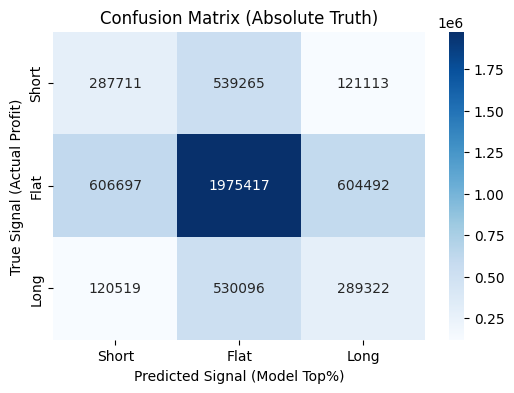

--- Best_L2 (Smooth) Regression Metrics ---
R2 (OOS): 0.030506
IC      : 0.178471 (Pearson)
RankIC  : 0.216099 (Spearman, 核心指标)
Best_L2 (Smooth)     | 0.01       | 0.0328     | 0.1785  

=== 诊断分析: 最优 L1 与 最优 L2 的殊途同归 ===
L1 模型 (Alpha=Optimized) 非零特征数: 14 / 16
L2 模型 (Alpha=Optimized) 非零特征数: 15 / 16


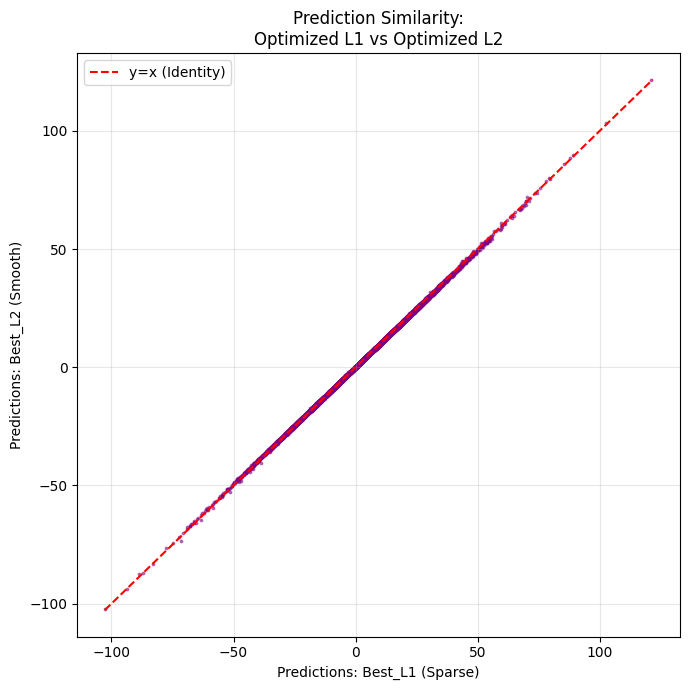

In [14]:
from sklearn.linear_model import ElasticNet
from sklearn.metrics import r2_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ===========================
# 3. 线性基准 (Elastic Net) - 验证集调优加强版
# ===========================

# 定义我们要对比的两类模型配置（固定 l1_ratio，只调优 alpha）
model_scenarios = [
    # 场景 A: 强 L1 (特征选择模式) -> 类似于 Lasso
    {"name": "Best_L1 (Sparse)", "l1_ratio": 1.0, "color": "red"},
    
    # 场景 B: 强 L2 (因子平滑模式) -> 类似于 Ridge
    # 注: ElasticNet l1_ratio=0 不稳定，用 0.001 近似 L2
    {"name": "Best_L2 (Smooth)", "l1_ratio": 0.001, "color": "blue"}
]

# 定义超参数网格 (正则化强度)
alpha_grid = [0.0001, 0.001, 0.01, 0.1, 1.0]

# 存储最终用于画图的数据
results_for_plot = []
coef_comparison = {}

print(f"{'Scenario':<20} | {'Best Alpha':<10} | {'Val R2':<10} | {'Test IC':<8}")
print("-" * 65)

for scenario in model_scenarios:
    l1_ratio = scenario['l1_ratio']
    
    # --- 阶段 1: 验证集调优 (Hyperparameter Tuning) ---
    best_score = -np.inf
    best_alpha = None
    
    for alpha in alpha_grid:
        # 训练 (Train Set)
        model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=42)
        model.fit(X_train, y_train)
        
        # 验证 (Validation Set)
        y_val_pred = model.predict(X_val)
        val_score = r2_score(y_val, y_val_pred)
        
        # 记录最佳参数
        if val_score > best_score:
            best_score = val_score
            best_alpha = alpha
    
    # --- 阶段 2: 最佳模型最终测试 (Final Evaluation) ---
    # 使用找到的最佳 alpha 重新实例化模型
    # (可选：这里可以使用 pd.concat([X_train, X_val]) 重新训练以利用更多数据)
    final_model = ElasticNet(alpha=best_alpha, l1_ratio=l1_ratio, random_state=42)
    final_model.fit(X_train, y_train)
    
    # 测试 (Test Set)
    y_test_pred = final_model.predict(X_test)
    
    # 存储用于后续对比的数据
    coef_comparison[scenario['name']] = final_model.coef_
    results_for_plot.append({
        'name': scenario['name'],
        'pred': y_test_pred,
        'color': scenario['color']
    })
    
    # 计算测试集指标
    test_metrics = evaluate_regression(y_test, y_test_pred, model_name=scenario['name'])
    
    # 打印调优结果摘要
    print(f"{scenario['name']:<20} | {best_alpha:<10} | {best_score:<10.4f} | {test_metrics['IC']:<8.4f}")
    
    # 如果是 L1 模型，额外做一次详细分类报告
    if l1_ratio > 0.5:
        evaluate_classification_comprehensive(y_test, y_test_pred, quantile=0.2)
    
    leaderboard.append(test_metrics)

# ===========================
# 4. 诊断：最佳 L1 vs 最佳 L2 的结构差异
# ===========================
print("\n=== 诊断分析: 最优 L1 与 最优 L2 的殊途同归 ===")

# A. 检查非零系数数量 (Sparsity)
# 看看验证集选出来的最佳 L1 是否真的把很多系数压为0了
name_l1 = "Best_L1 (Sparse)"
name_l2 = "Best_L2 (Smooth)"

coef_l1 = coef_comparison[name_l1]
coef_l2 = coef_comparison[name_l2]

# 设定一个极小阈值判断是否为0
nonzero_l1 = np.sum(np.abs(coef_l1) > 1e-5)
nonzero_l2 = np.sum(np.abs(coef_l2) > 1e-5)
total_feats = len(coef_l1)

print(f"L1 模型 (Alpha={model_scenarios[0].get('best_alpha', 'Optimized')}) 非零特征数: {nonzero_l1} / {total_feats}")
print(f"L2 模型 (Alpha={model_scenarios[1].get('best_alpha', 'Optimized')}) 非零特征数: {nonzero_l2} / {total_feats}")

# B. 绘制预测值相关性散点图
pred_l1 = results_for_plot[0]['pred']
pred_l2 = results_for_plot[1]['pred']

plt.figure(figsize=(7, 7))
plt.scatter(pred_l1, pred_l2, alpha=0.5, s=3, c='purple')

# 画对角线 (Perfect Correlation Line)
min_val = min(pred_l1.min(), pred_l2.min())
max_val = max(pred_l1.max(), pred_l2.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='y=x (Identity)', linewidth=1.5)

plt.title(f"Prediction Similarity:\nOptimized L1 vs Optimized L2")
plt.xlabel(f"Predictions: {name_l1}")
plt.ylabel(f"Predictions: {name_l2}")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [5]:
# from sklearn.ensemble import RandomForestRegressor

# # ===========================
# # 5. 随机森林 (Random Forest)
# # ===========================
# model_name = "RandomForest"
# print(f">>> Training {model_name} ...")

# rf = RandomForestRegressor(
#     n_estimators=30,      # 树数量控制在30以保证速度
#     max_depth=12,         # 限制深度防止过拟合 [cite: 688]
#     min_samples_leaf=100,
#     n_jobs=-1,
#     random_state=42,
#     verbose=0
# )

# rf.fit(X_train, y_train)
# y_pred_rf = rf.predict(X_test)

# # 评估
# metrics = evaluate_regression(y_test, y_pred_rf, model_name)
# evaluate_classification_comprehensive(y_test, y_pred_rf, quantile=0.2)
# leaderboard.append(metrics)

>>> Training XGBoost ...
[0]	validation_0-rmse:13.40780
[50]	validation_0-rmse:13.15443
[100]	validation_0-rmse:13.11286
[150]	validation_0-rmse:13.09861
[199]	validation_0-rmse:13.09215
--- XGBoost Regression Metrics ---
R2 (OOS): 0.046105
IC      : 0.217510 (Pearson)
RankIC  : 0.220688 (Spearman, 核心指标)

--- Classification Metrics (Pred Top 20% vs Absolute Truth) ---
Accuracy : 0.5301
Kappa    : 0.1438
MCC      : 0.1440
Long Precision : 0.3106
Short Precision: 0.3088

Detailed Report:
              precision    recall  f1-score   support

       Short     0.3088    0.3306    0.3193    948089
        Flat     0.6770    0.6469    0.6616   3186606
        Long     0.3106    0.3353    0.3225    939937

    accuracy                         0.5301   5074632
   macro avg     0.4321    0.4376    0.4345   5074632
weighted avg     0.5404    0.5301    0.5348   5074632



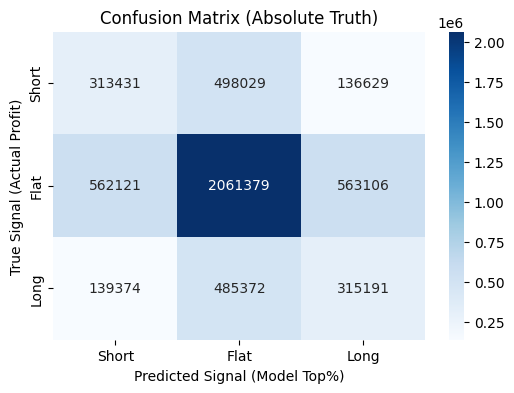

In [12]:
from xgboost import XGBRegressor

# ===========================
# 6. XGBoost
# ===========================
model_name = "XGBoost"
print(f">>> Training {model_name} ...")

xgb = XGBRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    n_jobs=-1,
    random_state=42,
    tree_method='hist', # 直方图加速 [cite: 708]
    early_stopping_rounds=20
)

# 使用验证集早停
xgb.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=50
)

y_pred_xgb = xgb.predict(X_test)

# 评估
metrics = evaluate_regression(y_test, y_pred_xgb, model_name)
evaluate_classification_comprehensive(y_test, y_pred_xgb, quantile=0.2)
leaderboard.append(metrics)

>>> Training LightGBM ...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.222776 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 25655084, number of used features: 15
[LightGBM] [Info] Start training from score 0.007420
Training until validation scores don't improve for 20 rounds
[50]	valid_0's rmse: 13.1586	valid_0's l2: 173.15
[100]	valid_0's rmse: 13.1095	valid_0's l2: 171.86
[150]	valid_0's rmse: 13.0915	valid_0's l2: 171.388
[200]	valid_0's rmse: 13.0831	valid_0's l2: 171.166
[250]	valid_0's rmse: 13.0789	valid_0's l2: 171.058
[300]	valid_0's rmse: 13.0769	valid_0's l2: 171.004
[350]	valid_0's rmse: 13.0756	valid_0's l2: 170.972
[400]	valid_0's rmse: 13.0755	valid_0's l2: 170.969
Early stopping, best iteration is:
[381]	valid_0's rmse: 13.075	valid_0's l2: 170.956
--- L

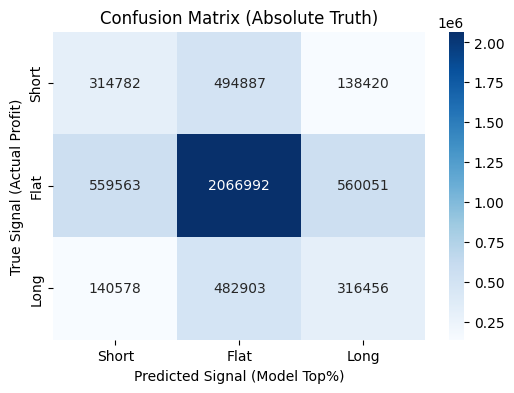

In [13]:
import lightgbm as lgb

# ===========================
# 7. LightGBM
# ===========================
model_name = "LightGBM"
print(f">>> Training {model_name} ...")

lgbm = lgb.LGBMRegressor(
    n_estimators=500,
    learning_rate=0.03,
    num_leaves=63,       # Leaf-wise 生长 [cite: 708]
    n_jobs=-1,
    random_state=42
)

lgbm.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric='rmse',
    callbacks=[
        lgb.early_stopping(20),
        lgb.log_evaluation(50)
    ]
)

y_pred_lgbm = lgbm.predict(X_test)

# 评估
metrics = evaluate_regression(y_test, y_pred_lgbm, model_name)
evaluate_classification_comprehensive(y_test, y_pred_lgbm, quantile=0.2)
leaderboard.append(metrics)


   🏆 Model Leaderboard (by RankIC) 🏆   


,R2,IC,RankIC
Model,,,
XGBoost,0.046105,0.217510,0.220688
LightGBM,0.047780,0.222954,0.220568
Best_L1 (Sparse),0.030402,0.178467,0.216176
Best_L2 (Smooth),0.030506,0.178471,0.216099


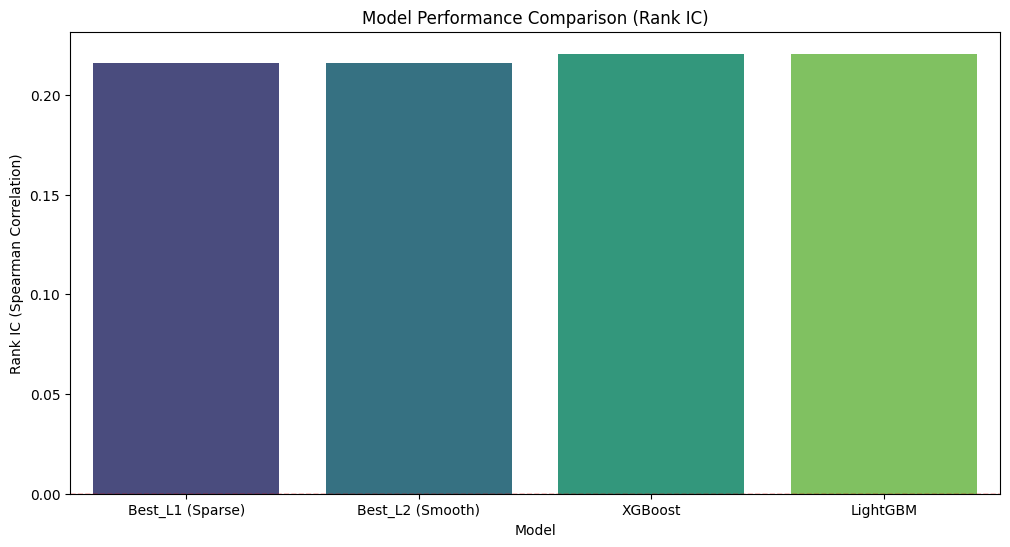

In [8]:
# ===========================
# 8. 最终排行榜
# ===========================
df_board = pd.DataFrame(leaderboard).set_index('Model')

print("\n========================================")
print("   🏆 Model Leaderboard (by RankIC) 🏆   ")
print("========================================")
# 按 RankIC 排序
display(df_board.sort_values('RankIC', ascending=False))

# 可视化对比
plt.figure(figsize=(12, 6))
sns.barplot(x=df_board.index, y='RankIC', data=df_board, palette='viridis')
plt.title('Model Performance Comparison (Rank IC)')
plt.ylabel('Rank IC (Spearman Correlation)')
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.show()


=== 预测结果分析图 ===
模型: Elastic Net L1


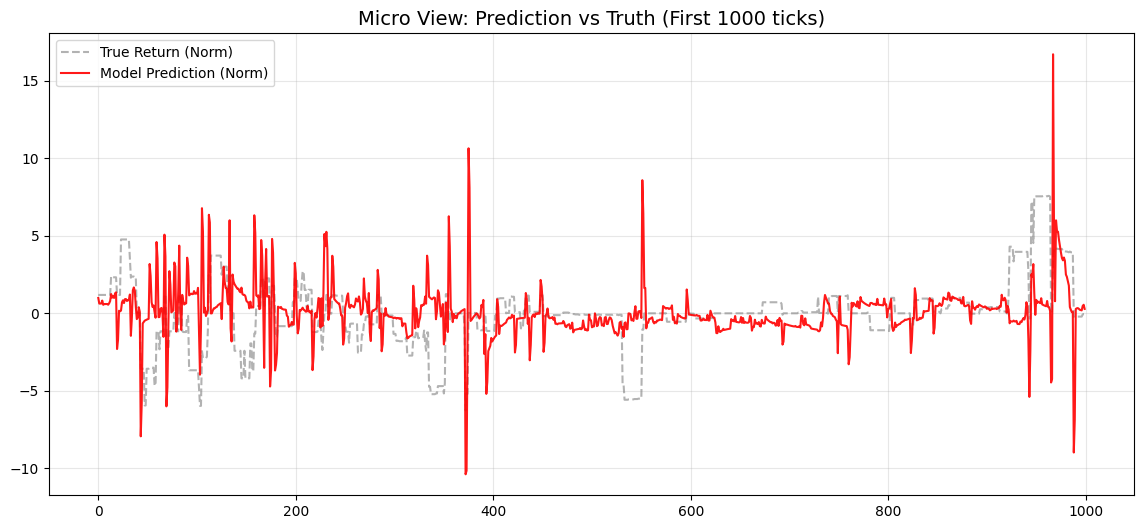

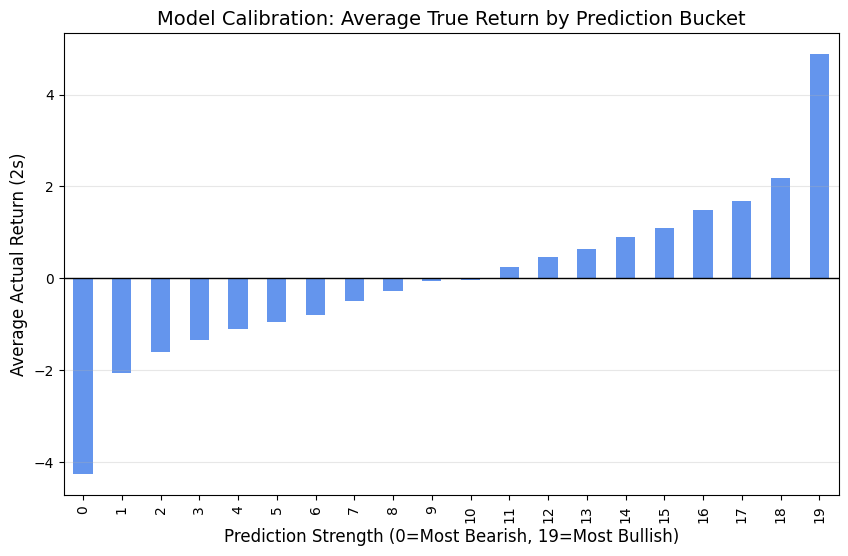

模型: Elastic Net L2


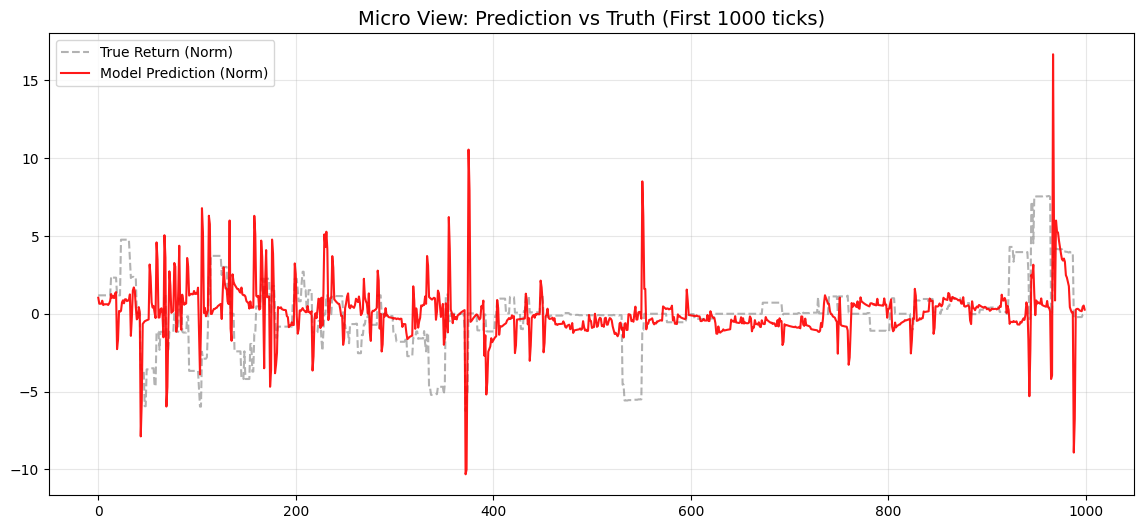

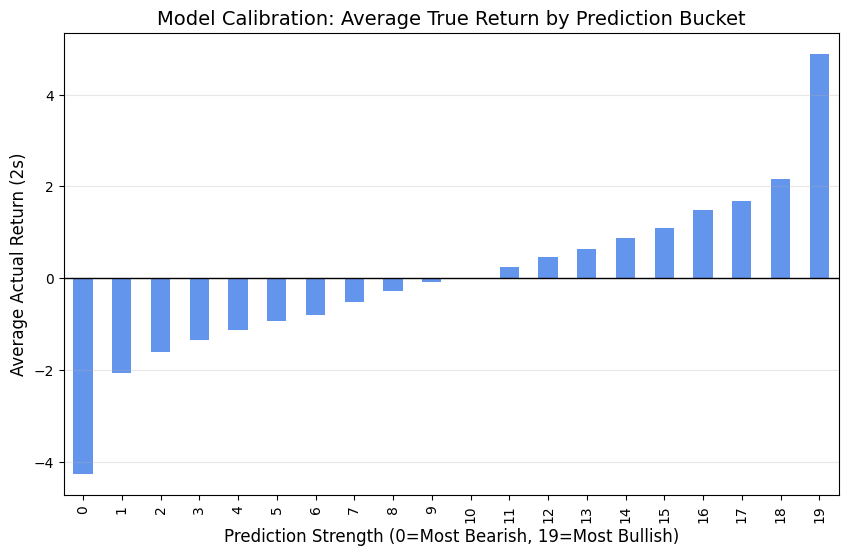

模型: XGBoost


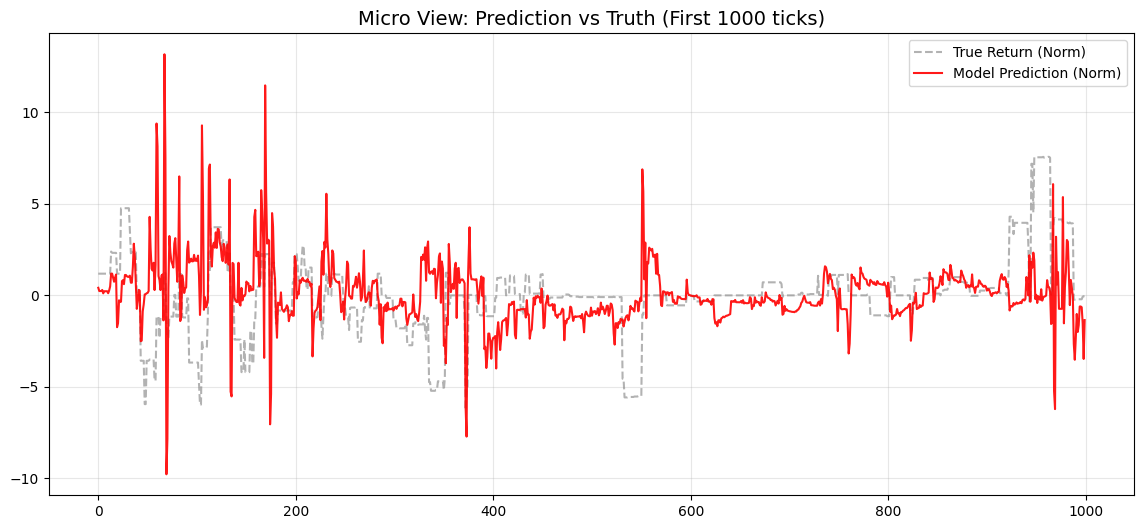

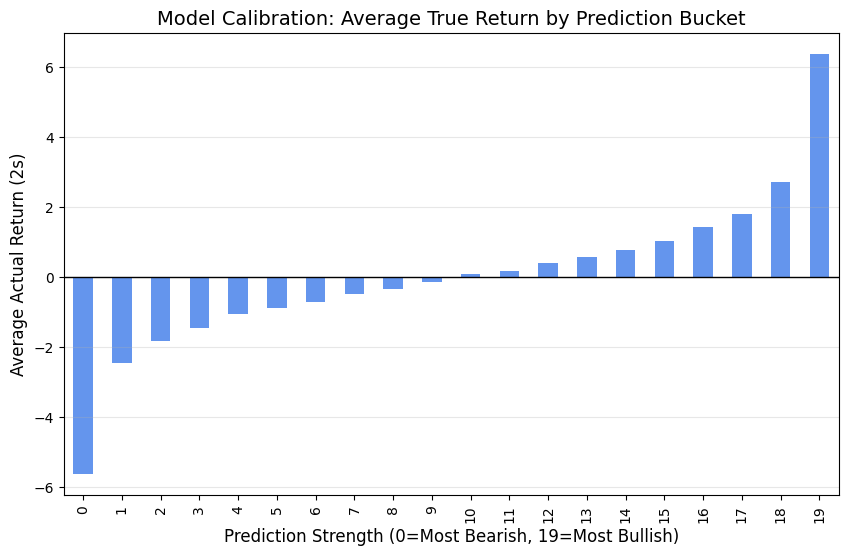

模型: LightGBM


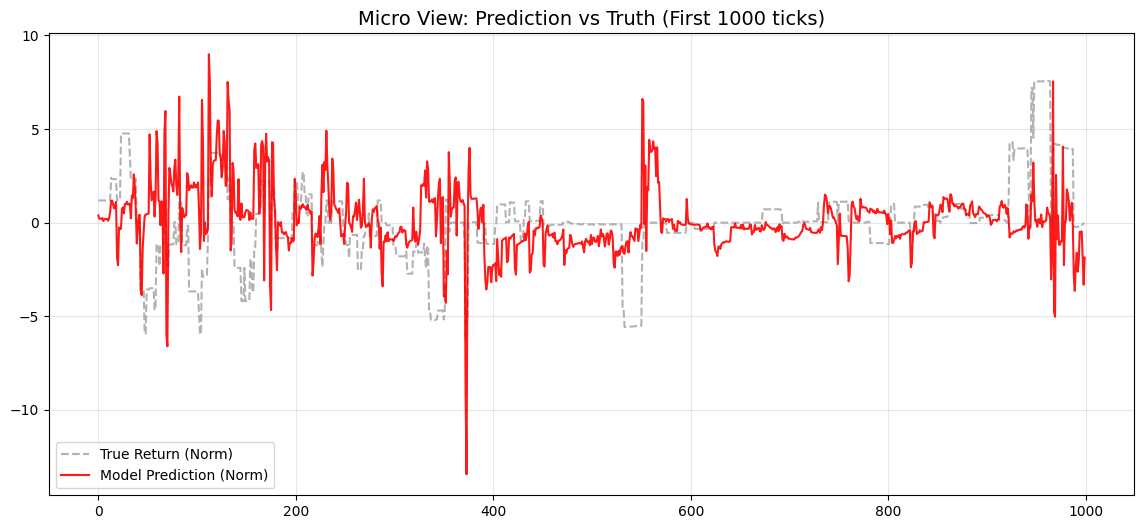

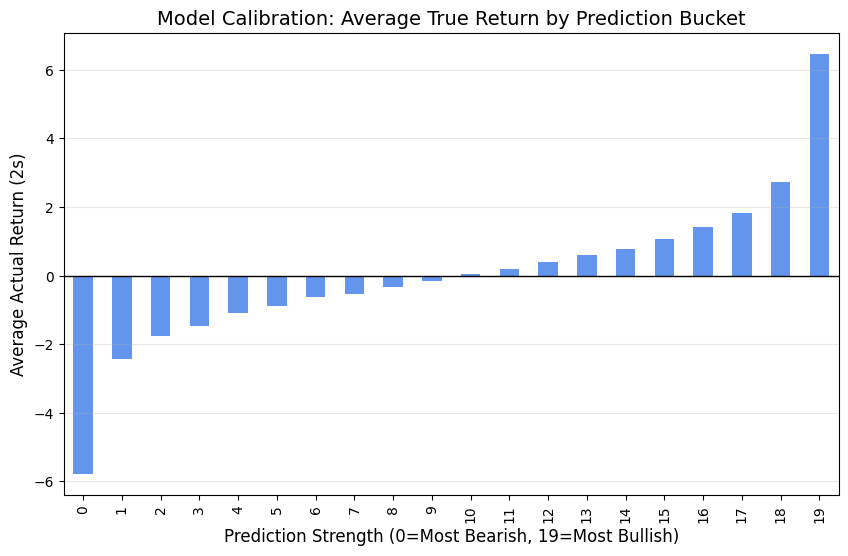

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def plot_prediction_analysis(y_true, y_pred, sample_size=1000):
    # 1. 微观视角：时间序列片段 (Time-Series Zoom)
    plt.figure(figsize=(14, 6))
    
    # 为了画图清晰，先做一下标准化归一 (Z-Score) 让它们在同一个尺度
    # 注意：这只为了画图好看，不改变相关性
    y_true_norm = (y_true - y_true.mean()) / y_true.std()
    y_pred_norm = (y_pred - y_pred.mean()) / y_pred.std()
    
    plt.plot(y_true_norm[:sample_size].values, label='True Return (Norm)', alpha=0.6, color='gray', linestyle='--')
    plt.plot(y_pred_norm[:sample_size], label='Model Prediction (Norm)', alpha=0.9, color='red', linewidth=1.5)
    
    plt.title(f'Micro View: Prediction vs Truth (First {sample_size} ticks)', fontsize=14)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

    # 2. 宏观视角：分组收益率 (Calibration / Lift Chart)
    # 这是量化最核心的图：预测分越高，实际收益率应该越高
    df = pd.DataFrame({'pred': y_pred, 'true': y_true})
    
    # 将预测值分成 20 组 (5% 一组)
    df['bucket'] = pd.qcut(df['pred'], q=20, labels=False, duplicates='drop')
    
    # 计算每组的平均真实收益率
    bucket_returns = df.groupby('bucket')['true'].mean()
    
    plt.figure(figsize=(10, 6))
    bucket_returns.plot(kind='bar', color='cornflowerblue')
    plt.title('Model Calibration: Average True Return by Prediction Bucket', fontsize=14)
    plt.xlabel('Prediction Strength (0=Most Bearish, 19=Most Bullish)', fontsize=12)
    plt.ylabel('Average Actual Return (2s)', fontsize=12)
    plt.axhline(0, color='black', linestyle='-', linewidth=1)
    plt.grid(axis='y', alpha=0.3)
    plt.show()

# --- 执行画图 (假设模型叫 xgb，数据是 X_test, y_test) ---
# 确保 y_pred 已生成
# y_pred_xgb = xgb.predict(X_test) 

# 调用
print("\n=== 预测结果分析图 ===")
print("模型: Elastic Net L1")
plot_prediction_analysis(y_test, results_for_plot[0]['pred'])
print("模型: Elastic Net L2")
plot_prediction_analysis(y_test, results_for_plot[1]['pred'])
print("模型: XGBoost")
plot_prediction_analysis(y_test, y_pred_xgb) # 替换为你当前模型对应的变量名
print("模型: LightGBM")
plot_prediction_analysis(y_test, y_pred_lgbm) 


   🔍 模型特征重要性深度解析 (Feature Insights)

[1] Elastic Net 系数分析 (Top 15 绝对值)


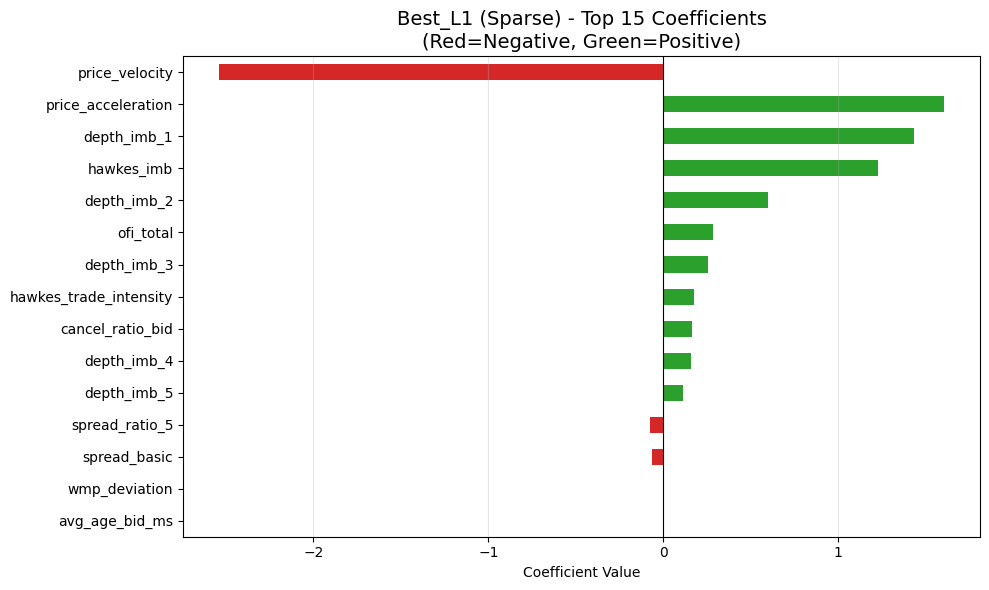

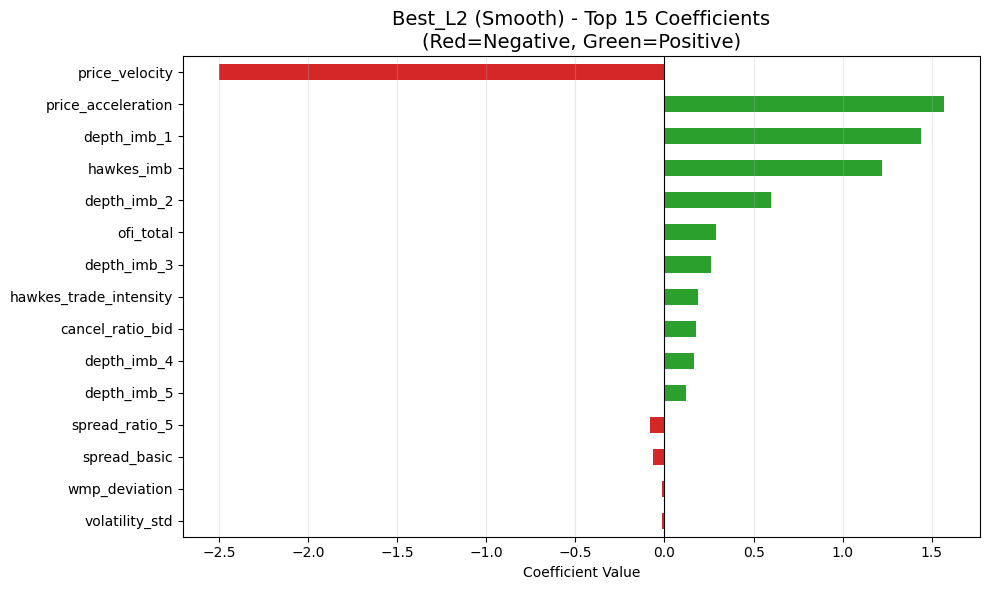


[2] 树模型特征重要性 (Feature Importance)


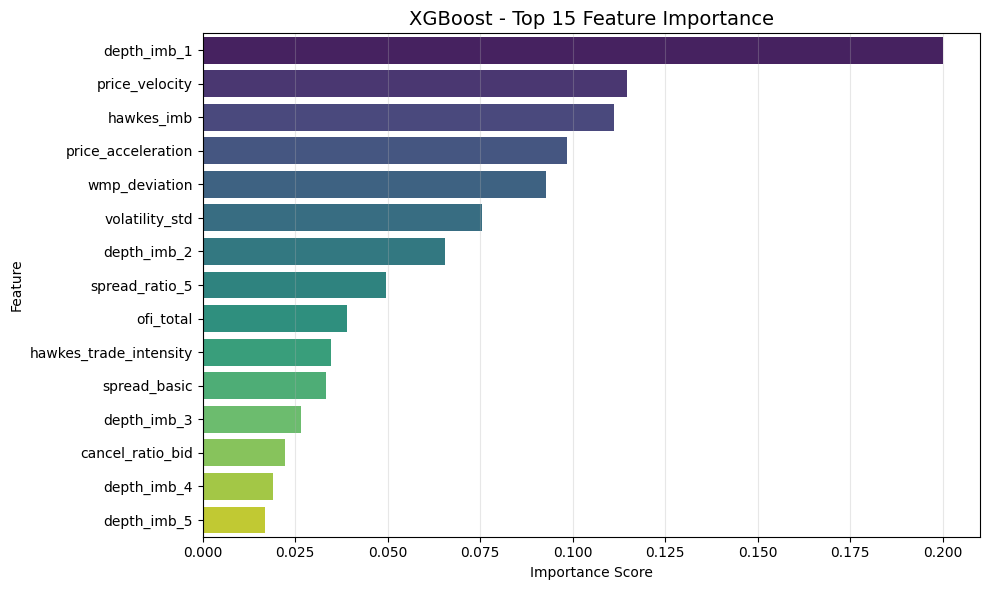

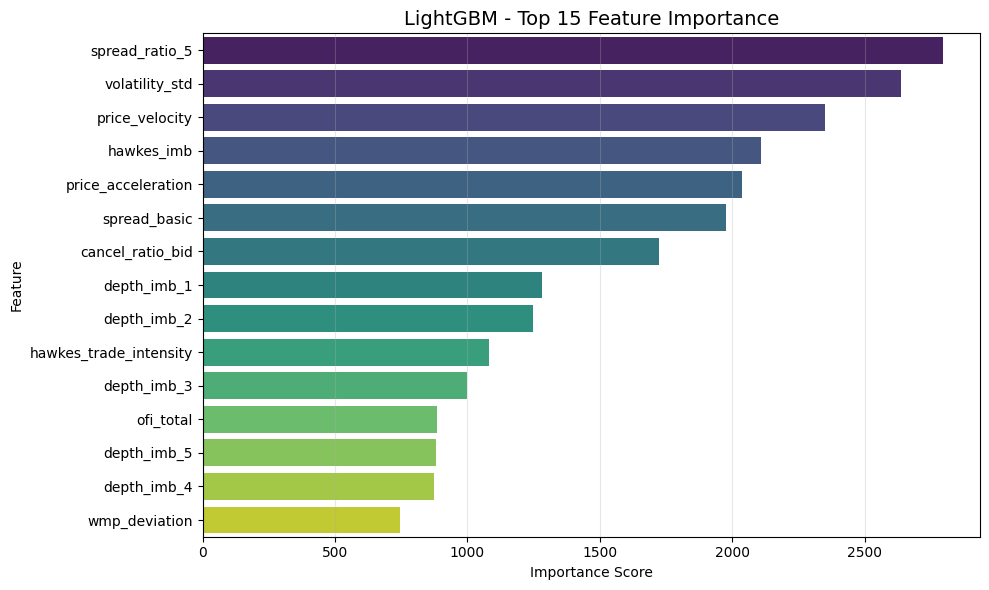

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_model_insights(feature_cols):
    """
    绘制线性模型的系数和树模型的特征重要性
    """
    print("\n" + "="*60)
    print("   🔍 模型特征重要性深度解析 (Feature Insights)")
    print("="*60)

    # --- 1. 线性模型 (Elastic Net) 系数分析 ---
    # 假设 coef_comparison 已经在之前的步骤中生成 (存储了 L1 和 L2 的系数)
    if 'coef_comparison' in globals() and len(coef_comparison) > 0:
        print("\n[1] Elastic Net 系数分析 (Top 15 绝对值)")
        
        # 将字典转换为 DataFrame
        df_coefs = pd.DataFrame(coef_comparison, index=feature_cols)
        
        # 针对每种配置画图
        for name in df_coefs.columns:
            # 按绝对值排序取 Top 15
            top_coefs = df_coefs[name].abs().sort_values(ascending=False).head(15)
            # 取出原始带符号的系数
            plot_data = df_coefs.loc[top_coefs.index, name]
            
            plt.figure(figsize=(10, 6))
            colors = ['#d62728' if x < 0 else '#2ca02c' for x in plot_data]
            plot_data.plot(kind='barh', color=colors)
            plt.title(f'{name} - Top 15 Coefficients\n(Red=Negative, Green=Positive)', fontsize=14)
            plt.xlabel('Coefficient Value')
            plt.axvline(0, color='black', linewidth=0.8)
            plt.grid(axis='x', alpha=0.3)
            plt.gca().invert_yaxis() # 让最大的在上面
            plt.tight_layout()
            plt.show()
    else:
        print("⚠️ 未找到 Elastic Net 系数数据 (coef_comparison)，跳过线性模型分析。")

    # --- 2. 树模型特征重要性 (XGBoost / LightGBM / Random Forest) ---
    
    tree_models = []
    if 'xgb' in globals(): tree_models.append(('XGBoost', xgb))
    if 'lgbm' in globals(): tree_models.append(('LightGBM', lgbm))
    if 'rf' in globals(): tree_models.append(('Random Forest', rf))
    
    if tree_models:
        print("\n[2] 树模型特征重要性 (Feature Importance)")
        
        for model_name, model in tree_models:
            try:
                # 获取重要性
                importances = model.feature_importances_
                
                # 创建 DataFrame
                df_imp = pd.DataFrame({
                    'Feature': feature_cols,
                    'Importance': importances
                }).sort_values('Importance', ascending=False).head(15)
                
                # 画图
                plt.figure(figsize=(10, 6))
                sns.barplot(x='Importance', y='Feature', data=df_imp, palette='viridis')
                plt.title(f'{model_name} - Top 15 Feature Importance', fontsize=14)
                plt.xlabel('Importance Score')
                plt.grid(axis='x', alpha=0.3)
                plt.tight_layout()
                plt.show()
                
            except Exception as e:
                print(f"无法绘制 {model_name} 的特征重要性: {e}")
    else:
        print("⚠️ 未找到已训练的树模型 (xgb, lgbm, rf)，跳过树模型分析。")

# 执行分析
if 'feature_cols' in globals():
    plot_model_insights(feature_cols)
else:
    print("请先运行数据加载部分以定义 feature_cols。")